# Detecting spouse mentions in sentences

We will walk through an example text classification task to explore how Snorkel works with user-defined LFs. Run every cell in the notebook (unless otherwise noted) before proceeding to the next one!
## Classification Task
<img src="imgs/sentence.jpg" width="700px;">

We want to classify each __candidate__ or pair of people mentioned in a sentence, as being married at some point or not.

In the above example, our candidate represents the possible relation `(Barack Obama, Michelle Obama)`. As readers, we know this mention is true due to external knowledge and the keyword of `wedding` occuring later in the sentence.
We begin with some basic setup and data downloading.


In [1]:
%matplotlib inline

import os
import pickle
import tensorflow as tf
import numpy as np

if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spouse")

from utils import load_data

((dev_df, dev_labels), train_df, (test_df, test_labels)) = load_data()

**Input Data:** `dev_df` is a Pandas DataFrame object, where each row represents a particular __candidate__. The DataFrames contain the fields `sentence`, which refers to the sentence the candidate is in, `tokens`, the tokenized form of the sentence, `person1_word_idx` and `person2_word_idx`, which represent `[start, end]` indices in the tokens at which the first and second person's name appear, respectively.

We also have certain **preprocessed fields**, that we discuss a few cells below. We have other tutorials focused on generating such datasets (e.g., from richy-formatted data), but assume we have access to a Pandas DataFrame for the purpose of this specific tutorial!

In [2]:
dev_df.head()

,person1_word_idx,person2_word_idx,sentence,tokens,person1_right_tokens,person2_right_tokens,between_tokens
0,"(1, 1)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[., ]","[are, half, -, sisters, to, Kathy, Hilton, ,, ..."
1,"(1, 1)","(7, 8)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[,, the, mother, of]","[are, half, -, sisters, to]"
2,"(7, 8)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[,, the, mother, of]","[., ]","[,, the, mother, of, socialite, Paris, Hilton,..."
3,"(6, 6)","(20, 21)","Prior to both his guests, Colbert's monologue ...","[Prior, to, both, his, guests, ,, Colbert, s, ...","[s, monologue, -, parts]","[and, his, oft, -]","[s, monologue, -, parts, of, which, he, did, s..."
4,"(2, 2)","(4, 5)",People reported Williams and Ven Veen tied the...,"[People, reported, Williams, and, Ven, Veen, t...","[and, Ven, Veen, tied]","[tied, the, knot, Saturday]",[and]


You'll interact with these candidates while writing labeling functions in Snorkel. We look at a candidate in the development set:

In [3]:
from preprocessors import get_person_text

candidate = dev_df.loc[2]
person_names = get_person_text(candidate).person_names

print("Sentence: ", candidate["sentence"])
print("Person 1: ", person_names[0])
print("Person 2: ", person_names[1])

Sentence:  The Richards are half-sisters to Kathy Hilton, the mother of socialite Paris Hilton and spouse of luxury hotel magnate Richard Howard Hilton.   
Person 1:  Kathy Hilton
Person 2:  Richard Howard Hilton


# Part 2: Writing  Labeling Functions

In Snorkel, our primary interface through which we provide training signal to the end extraction model we are training is by writing **labeling functions (LFs)** (as opposed to hand-labeling massive training sets).  We'll go through some examples for our spouse classification task below.

A labeling function is a Python function that accepts a candidate, or a row of the DataFrame, as the input argument and outputs a label for the candidate. For ease of exposition in this notebook, we return `1` if it says the pair of persons in the candidate were married at some point,  `-1` if the pair of persons in the candidate were never married, and `0` if it doesn't know how to vote and abstains. In practice, many labeling functions are often unipolar: it labels only `1`s and `0`s, or it labels only `-1`s and `0`s.

(Note we will change our mapping to use `2` to represent the absence of a relationship to match the multiclass convention when feeding it to the LabelModel later.)
Recall that our goal is to ultimately train a high-performance classification model that predicts which of our candidates are true spouse relations. It turns out that we can do this by writing potentially low-quality labeling functions!

#  I. Background

## Preprocessing the Database

In a real application, there is a lot of data preparation, parsing, and database loading that needs to be completed before we dive into writing labeling functions. Here we've pre-generated candidates in a pandas DataFrame object per split (train,dev,test).

###  Using a _Development Set_ of Human-labeled Data

In our setting, we will use the phrase _development set_ to refer to a set of examples (here, a subset of our training set) which we label by hand and use to help us develop and refine labeling functions.  Unlike the _test set_, which we do not look at and use for final evaluation, we can inspect the development set while writing labeling functions. This is a list of `{-1,1}` labels.

### Labeling Function Helpers

When writing labeling functions, there are several operators you will use over and over again. In the case of text relation extraction as with this task, common operators include fetching text between mentions of the two people in a candidate, examing word windows around person mentions, etc. Note that other domains and tasks, the required preprocessors will be different.

We provide several helper functions in `preprocessors`:  these are Python helper functions that you can apply to candidates in the DataFrame to return objects that are helpful during LF development. You can (and should!) write your own helper functions to help write LFs.

We provide an example of a preprocessor definition here:

In [4]:
from snorkel.labeling.preprocess import preprocessor


@preprocessor
def get_text_between(cand):
    """
    Returns the text between the two person mentions in the sentence for a candidate
    """
    start = cand.person1_word_idx[1] + 1
    end = cand.person2_word_idx[0]
    cand.text_between = " ".join(cand.tokens[start:end])
    return cand

## Candidate PreProcessors

We provide a set of helper functions for this task in `preprocessors.py` that take as input a candidate, or row of a DataFrame in our case. For the purpose of the tutorial, we have two of these fields preprocessed in the data, which can be used when creating labeling functions.

`get_person_text(cand)`

`get_person_lastnames(cand)`

`get_between_tokens(cand)`

`get_left_tokens(cand)`

`get_right_tokens(cand)`

II. Labeling Functions

# A. Pattern Matching Labeling Functions

One powerful form of labeling function design is defining sets of keywords or regular expressions that, as a human labeler, you know are correlated with the true label. For example, we could define a dictionary of terms that occur between person names in a candidate. One simple dictionary of terms indicating a true relation could be, which we could use in a labeling function like shown below:

    spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}


    @labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
    def lf_husband_wife_left_window(x, spouses):
        if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
            return POSITIVE
        elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
            return POSITIVE
        else:
            return ABSTAIN

**Note that:**
1. To access the text between the person mentions, we can use the **`get_left_tokens` preprocessor!**
2. We use **resources like the spouses dictionary** to encode themes/categories of relationships!

There are a few advantages of having preprocessors and labeling functions in this form:

**Data Agnostic:**  Operate over multiple data types without rewriting

**Incremental Processing:** Can create preprocessors as needed while writing LFs!

**Future Use:** Can store them for later for different tasks since they are reproducible and modular

**Optimizations:** Allows caching behind-the-scenes

In [5]:
from snorkel.labeling.apply import PandasLFApplier
from snorkel.labeling.lf import labeling_function

from preprocessors import get_left_tokens, get_person_last_names

POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

In [6]:
# Check for the `spouse` words appearing between the person mentions
spouses = {"spouse", "wife", "husband", "ex-wife", "ex-husband"}


@labeling_function(resources=dict(spouses=spouses))
def lf_husband_wife(x, spouses):
    return POSITIVE if len(spouses.intersection(set(x.between_tokens))) > 0 else ABSTAIN

In [7]:
# Check for the `spouse` words appearing to the left of the person mentions
@labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
def lf_husband_wife_left_window(x, spouses):
    if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
        return POSITIVE
    elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
        return POSITIVE
    else:
        return ABSTAIN

In [8]:
# Check for the person mentions having the same last name
@labeling_function(preprocessors=[get_person_last_names])
def lf_same_last_name(x):
    p1_ln, p2_ln = x.person_lastnames

    if p1_ln and p2_ln and p1_ln == p2_ln:
        return POSITIVE
    return ABSTAIN

In [9]:
# Check for the word `married` between person mentions
@labeling_function()
def lf_married(x):
    return POSITIVE if "married" in x.between_tokens else ABSTAIN

In [10]:
# Check for words that refer to `family` relationships between and to the left of the person mentions
family = {
    "father",
    "mother",
    "sister",
    "brother",
    "son",
    "daughter",
    "grandfather",
    "grandmother",
    "uncle",
    "aunt",
    "cousin",
}
family = family.union({f + "-in-law" for f in family})


@labeling_function(resources=dict(family=family))
def lf_familial_relationship(x, family):
    return NEGATIVE if len(family.intersection(set(x.between_tokens))) > 0 else ABSTAIN


@labeling_function(resources=dict(family=family), preprocessors=[get_left_tokens])
def lf_family_left_window(x, family):
    if len(set(family).intersection(set(x.person1_left_tokens))) > 0:
        return NEGATIVE
    elif len(set(family).intersection(set(x.person2_left_tokens))) > 0:
        return NEGATIVE
    else:
        return ABSTAIN

In [11]:
# Check for `other` relationship words between person mentions
other = {"boyfriend", "girlfriend", "boss", "employee", "secretary", "co-worker"}


@labeling_function(resources=dict(other=other))
def lf_other_relationship(x, other):
    return NEGATIVE if len(other.intersection(set(x.between_tokens))) > 0 else ABSTAIN

#### Apply Labeling Functions to the Data
We create a list of labeling functions and apply them to the data

In [12]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
]
applier = PandasLFApplier(lfs)
L = applier.apply(dev_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  2%|▏         | 65/2811 [00:00<00:04, 640.08it/s]

  5%|▍         | 131/2811 [00:00<00:04, 644.68it/s]

  7%|▋         | 195/2811 [00:00<00:04, 643.17it/s]

  9%|▉         | 259/2811 [00:00<00:03, 641.00it/s]

 12%|█▏        | 324/2811 [00:00<00:03, 643.33it/s]

 14%|█▍        | 387/2811 [00:00<00:03, 638.77it/s]

 16%|█▌        | 451/2811 [00:00<00:03, 639.07it/s]

 18%|█▊        | 516/2811 [00:00<00:03, 641.73it/s]

 21%|██        | 581/2811 [00:00<00:03, 642.42it/s]

 23%|██▎       | 647/2811 [00:01<00:03, 646.75it/s]

 25%|██▌       | 712/2811 [00:01<00:03, 645.13it/s]

 28%|██▊       | 778/2811 [00:01<00:03, 647.33it/s]

 30%|██▉       | 843/2811 [00:01<00:03, 645.44it/s]

 32%|███▏      | 908/2811 [00:01<00:02, 645.11it/s]

 35%|███▍      | 974/2811 [00:01<00:02, 646.79it/s]

 37%|███▋      | 1039/2811 [00:01<00:02, 644.07it/s]

 39%|███▉      | 1104/2811 [00:01<00:02, 643.24it/s]

 42%|████▏     | 1170/2811 [00:01<00:02, 645.88it/s]

 44%|████▍     | 1235/2811 [00:01<00:02, 645.38it/s]

 46%|████▌     | 1300/2811 [00:02<00:02, 645.69it/s]

 49%|████▊     | 1366/2811 [00:02<00:02, 648.58it/s]

 51%|█████     | 1432/2811 [00:02<00:02, 649.15it/s]

 53%|█████▎    | 1497/2811 [00:02<00:02, 648.65it/s]

 56%|█████▌    | 1563/2811 [00:02<00:01, 649.12it/s]

 58%|█████▊    | 1628/2811 [00:02<00:01, 646.94it/s]

 60%|██████    | 1693/2811 [00:02<00:01, 647.63it/s]

 63%|██████▎   | 1758/2811 [00:02<00:01, 647.66it/s]

 65%|██████▍   | 1823/2811 [00:02<00:01, 644.99it/s]

 67%|██████▋   | 1889/2811 [00:02<00:01, 646.99it/s]

 70%|██████▉   | 1955/2811 [00:03<00:01, 649.67it/s]

 72%|███████▏  | 2020/2811 [00:03<00:01, 646.01it/s]

 74%|███████▍  | 2085/2811 [00:03<00:01, 643.17it/s]

 76%|███████▋  | 2150/2811 [00:03<00:01, 644.53it/s]

 79%|███████▉  | 2215/2811 [00:03<00:00, 645.18it/s]

 81%|████████  | 2281/2811 [00:03<00:00, 646.70it/s]

 83%|████████▎ | 2346/2811 [00:03<00:00, 646.87it/s]

 86%|████████▌ | 2411/2811 [00:03<00:00, 647.69it/s]

 88%|████████▊ | 2476/2811 [00:03<00:00, 643.54it/s]

 90%|█████████ | 2541/2811 [00:03<00:00, 645.22it/s]

 93%|█████████▎| 2606/2811 [00:04<00:00, 646.54it/s]

 95%|█████████▌| 2671/2811 [00:04<00:00, 646.48it/s]

 97%|█████████▋| 2736/2811 [00:04<00:00, 645.49it/s]

100%|█████████▉| 2801/2811 [00:04<00:00, 646.03it/s]

100%|██████████| 2811/2811 [00:04<00:00, 645.26it/s]

### Labeling Function Metrics

We can use the lf_summary function to measure various coverage related metrics for LFs. If we have gold labeled data, we can also evaluate accuracy.

#### Polarity
The set of label values the LF can output when it doesn't abstain. It is common for each LF to have a single polarity.

#### Coverage
The fraction of candidates that is labeled by our LF.

#### Overlaps
The fraction of examples labeled by the LF that is also labeled by another LF.

#### Conflicts
The fraction of examples labeled by the LF that is given a different (non-abstain) label by another LF.

#### Correct
The number of correctly labeled examples on the gold labeled data.

#### Incorrect
The number of incorrectly labeled examples on the gold labeled data.

#### Empirical Accuracy
The fraction of correctly labeled examples on the gold data.

In [13]:
from snorkel.labeling.analysis import LFAnalysis

lf_names = [lf.name for lf in lfs]
LFAnalysis(L).lf_summary(dev_labels, lf_names=lf_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_husband_wife,0,[1],0.089648,0.036642,0.017432,93,159,0.369048
lf_husband_wife_left_window,1,[1],0.025258,0.021345,0.003557,30,41,0.422535
lf_same_last_name,2,[1],0.040555,0.016009,0.008538,19,95,0.166667
lf_married,3,[1],0.019210,0.006403,0.002490,22,32,0.407407
lf_familial_relationship,4,[0],0.115617,0.051583,0.025969,310,15,0.953846
lf_family_left_window,5,[0],0.041266,0.033440,0.007826,114,2,0.982759
lf_other_relationship,6,[0],0.013874,0.002846,0.002846,33,6,0.846154


## B. Distant Supervision Labeling Functions

In addition to using factories that encode pattern matching heuristics, we can also write labeling functions that _distantly supervise_ examples. Here, we'll load in a list of known spouse pairs and check to see if the pair of persons in a candidate matches one of these.

**DBpedia**
http://wiki.dbpedia.org/
Our database of known spouses comes from DBpedia, which is a community-driven resource similar to Wikipedia but for curating structured data. We'll use a preprocessed snapshot as our knowledge base for all labeling function development.

We can look at some of the example entries from DBPedia and use them in a simple distant supervision labeling function.

Make sure `dbpedia.pkl` is in the `spouse/data` directory.

In [14]:
with open("data/dbpedia.pkl", "rb") as f:
    known_spouses = pickle.load(f)

list(known_spouses)[0:5]

[('Sir Wilfrid Laurier', 'Zoé Lafontaine Lady Laurier'),
 ('Rebecca Saire', 'Roger Allam'),
 ('Mary Maxwell Gates', 'William Henry Gates Sr.'),
 ('Rabbi Peter E. Tarlow', 'Sara Alpern Tarlow'),
 ('Charles Frederick', 'Grand Duchess Anna Petrovna')]

In [15]:
@labeling_function(
    resources=dict(known_spouses=known_spouses), preprocessors=[get_person_text]
)
def lf_distant_supervision(x, known_spouses):
    p1, p2 = x.person_names
    if (p1, p2) in known_spouses or (p2, p1) in known_spouses:
        return POSITIVE
    else:
        return ABSTAIN

In [16]:
from preprocessors import last_name

# Last name pairs for known spouses
last_names = set(
    [
        (last_name(x), last_name(y))
        for x, y in known_spouses
        if last_name(x) and last_name(y)
    ]
)


@labeling_function(
    resources=dict(last_names=last_names), preprocessors=[get_person_last_names]
)
def lf_distant_supervision_last_names(x, last_names):
    p1_ln, p2_ln = x.person_lastnames

    return (
        POSITIVE
        if (p1_ln != p2_ln)
        and ((p1_ln, p2_ln) in last_names or (p2_ln, p1_ln) in last_names)
        else ABSTAIN
    )

Every time you write a new labeling function, add it to appliers and make sure to include it in the new L matrix!

In [17]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
    lf_distant_supervision,
    lf_distant_supervision_last_names,
]
applier = PandasLFApplier(lfs)

In [18]:
dev_L = applier.apply(dev_df)

train_L = applier.apply(train_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  1%|▏         | 39/2811 [00:00<00:07, 384.20it/s]

  3%|▎         | 77/2811 [00:00<00:07, 382.38it/s]

  4%|▍         | 116/2811 [00:00<00:07, 383.05it/s]

  5%|▌         | 154/2811 [00:00<00:06, 382.12it/s]

  7%|▋         | 192/2811 [00:00<00:06, 380.33it/s]

  8%|▊         | 230/2811 [00:00<00:06, 378.01it/s]

 10%|▉         | 268/2811 [00:00<00:06, 378.40it/s]

 11%|█         | 307/2811 [00:00<00:06, 379.47it/s]

 12%|█▏        | 344/2811 [00:00<00:06, 375.78it/s]

 14%|█▎        | 382/2811 [00:01<00:06, 375.73it/s]

 15%|█▍        | 420/2811 [00:01<00:06, 374.84it/s]

 16%|█▋        | 459/2811 [00:01<00:06, 377.48it/s]

 18%|█▊        | 498/2811 [00:01<00:06, 379.20it/s]

 19%|█▉        | 536/2811 [00:01<00:06, 379.02it/s]

 20%|██        | 575/2811 [00:01<00:05, 380.40it/s]

 22%|██▏       | 614/2811 [00:01<00:05, 382.41it/s]

 23%|██▎       | 653/2811 [00:01<00:05, 382.81it/s]

 25%|██▍       | 692/2811 [00:01<00:05, 381.29it/s]

 26%|██▌       | 731/2811 [00:01<00:05, 382.69it/s]

 27%|██▋       | 770/2811 [00:02<00:05, 382.83it/s]

 29%|██▉       | 809/2811 [00:02<00:05, 381.77it/s]

 30%|███       | 848/2811 [00:02<00:05, 381.16it/s]

 32%|███▏      | 887/2811 [00:02<00:05, 382.86it/s]

 33%|███▎      | 926/2811 [00:02<00:04, 383.65it/s]

 34%|███▍      | 965/2811 [00:02<00:04, 384.59it/s]

 36%|███▌      | 1004/2811 [00:02<00:04, 382.11it/s]

 37%|███▋      | 1043/2811 [00:02<00:04, 381.49it/s]

 38%|███▊      | 1082/2811 [00:02<00:04, 379.85it/s]

 40%|███▉      | 1121/2811 [00:02<00:04, 380.75it/s]

 41%|████▏     | 1160/2811 [00:03<00:04, 380.90it/s]

 43%|████▎     | 1199/2811 [00:03<00:04, 381.70it/s]

 44%|████▍     | 1238/2811 [00:03<00:04, 381.00it/s]

 45%|████▌     | 1277/2811 [00:03<00:04, 381.83it/s]

 47%|████▋     | 1316/2811 [00:03<00:03, 382.28it/s]

 48%|████▊     | 1355/2811 [00:03<00:03, 383.69it/s]

 50%|████▉     | 1394/2811 [00:03<00:03, 384.14it/s]

 51%|█████     | 1433/2811 [00:03<00:03, 383.80it/s]

 52%|█████▏    | 1472/2811 [00:03<00:03, 384.31it/s]

 54%|█████▍    | 1511/2811 [00:03<00:03, 383.23it/s]

 55%|█████▌    | 1550/2811 [00:04<00:03, 383.73it/s]

 57%|█████▋    | 1589/2811 [00:04<00:03, 383.41it/s]

 58%|█████▊    | 1628/2811 [00:04<00:03, 381.10it/s]

 59%|█████▉    | 1667/2811 [00:04<00:02, 382.00it/s]

 61%|██████    | 1706/2811 [00:04<00:02, 381.45it/s]

 62%|██████▏   | 1745/2811 [00:04<00:02, 382.39it/s]

 63%|██████▎   | 1784/2811 [00:04<00:02, 381.98it/s]

 65%|██████▍   | 1823/2811 [00:04<00:02, 380.16it/s]

 66%|██████▌   | 1862/2811 [00:04<00:02, 381.83it/s]

 68%|██████▊   | 1901/2811 [00:04<00:02, 382.50it/s]

 69%|██████▉   | 1940/2811 [00:05<00:02, 383.76it/s]

 70%|███████   | 1979/2811 [00:05<00:02, 383.91it/s]

 72%|███████▏  | 2018/2811 [00:05<00:02, 380.86it/s]

 73%|███████▎  | 2057/2811 [00:05<00:01, 377.54it/s]

 75%|███████▍  | 2096/2811 [00:05<00:01, 378.48it/s]

 76%|███████▌  | 2135/2811 [00:05<00:01, 379.66it/s]

 77%|███████▋  | 2173/2811 [00:05<00:01, 379.57it/s]

 79%|███████▊  | 2212/2811 [00:05<00:01, 380.31it/s]

 80%|████████  | 2251/2811 [00:05<00:01, 381.36it/s]

 81%|████████▏ | 2290/2811 [00:06<00:01, 380.63it/s]

 83%|████████▎ | 2329/2811 [00:06<00:01, 380.75it/s]

 84%|████████▍ | 2368/2811 [00:06<00:01, 381.70it/s]

 86%|████████▌ | 2407/2811 [00:06<00:01, 382.54it/s]

 87%|████████▋ | 2446/2811 [00:06<00:00, 382.36it/s]

 88%|████████▊ | 2485/2811 [00:06<00:00, 383.06it/s]

 90%|████████▉ | 2524/2811 [00:06<00:00, 383.57it/s]

 91%|█████████ | 2563/2811 [00:06<00:00, 384.77it/s]

 93%|█████████▎| 2602/2811 [00:06<00:00, 383.60it/s]

 94%|█████████▍| 2641/2811 [00:06<00:00, 384.20it/s]

 95%|█████████▌| 2680/2811 [00:07<00:00, 383.77it/s]

 97%|█████████▋| 2719/2811 [00:07<00:00, 384.25it/s]

 98%|█████████▊| 2758/2811 [00:07<00:00, 383.04it/s]

100%|█████████▉| 2797/2811 [00:07<00:00, 383.02it/s]

100%|██████████| 2811/2811 [00:07<00:00, 381.36it/s]


  0%|          | 0/22254 [00:00<?, ?it/s]

  0%|          | 36/22254 [00:00<01:02, 355.36it/s]

  0%|          | 74/22254 [00:00<01:01, 361.37it/s]

  1%|          | 112/22254 [00:00<01:00, 366.23it/s]

  1%|          | 150/22254 [00:00<00:59, 368.44it/s]

  1%|          | 188/22254 [00:00<00:59, 371.21it/s]

  1%|          | 227/22254 [00:00<00:58, 373.89it/s]

  1%|          | 266/22254 [00:00<00:58, 376.34it/s]

  1%|▏         | 305/22254 [00:00<00:58, 377.44it/s]

  2%|▏         | 343/22254 [00:00<00:58, 377.60it/s]

  2%|▏         | 381/22254 [00:01<00:58, 376.29it/s]

  2%|▏         | 419/22254 [00:01<00:57, 376.82it/s]

  2%|▏         | 458/22254 [00:01<00:57, 378.20it/s]

  2%|▏         | 496/22254 [00:01<00:57, 378.39it/s]

  2%|▏         | 534/22254 [00:01<00:58, 374.36it/s]

  3%|▎         | 572/22254 [00:01<00:58, 373.46it/s]

  3%|▎         | 611/22254 [00:01<00:57, 376.05it/s]

  3%|▎         | 649/22254 [00:01<00:57, 375.17it/s]

  3%|▎         | 687/22254 [00:01<00:57, 374.98it/s]

  3%|▎         | 726/22254 [00:01<00:57, 377.41it/s]

  3%|▎         | 765/22254 [00:02<00:56, 378.68it/s]

  4%|▎         | 803/22254 [00:02<00:56, 378.86it/s]

  4%|▍         | 842/22254 [00:02<00:56, 379.52it/s]

  4%|▍         | 880/22254 [00:02<00:56, 378.50it/s]

  4%|▍         | 919/22254 [00:02<00:56, 379.61it/s]

  4%|▍         | 958/22254 [00:02<00:55, 380.72it/s]

  4%|▍         | 997/22254 [00:02<00:55, 380.28it/s]

  5%|▍         | 1036/22254 [00:02<00:55, 379.62it/s]

  5%|▍         | 1074/22254 [00:02<00:55, 378.95it/s]

  5%|▍         | 1112/22254 [00:02<00:55, 377.74it/s]

  5%|▌         | 1151/22254 [00:03<00:55, 378.76it/s]

  5%|▌         | 1190/22254 [00:03<00:55, 379.43it/s]

  6%|▌         | 1228/22254 [00:03<00:55, 379.21it/s]

  6%|▌         | 1267/22254 [00:03<00:55, 380.49it/s]

  6%|▌         | 1306/22254 [00:03<00:54, 381.61it/s]

  6%|▌         | 1345/22254 [00:03<00:54, 381.39it/s]

  6%|▌         | 1384/22254 [00:03<00:54, 381.64it/s]

  6%|▋         | 1423/22254 [00:03<00:55, 375.60it/s]

  7%|▋         | 1461/22254 [00:03<00:55, 375.79it/s]

  7%|▋         | 1499/22254 [00:03<00:55, 375.85it/s]

  7%|▋         | 1538/22254 [00:04<00:54, 377.39it/s]

  7%|▋         | 1576/22254 [00:04<00:54, 376.80it/s]

  7%|▋         | 1614/22254 [00:04<00:54, 377.28it/s]

  7%|▋         | 1653/22254 [00:04<00:54, 378.21it/s]

  8%|▊         | 1691/22254 [00:04<00:54, 377.93it/s]

  8%|▊         | 1729/22254 [00:04<00:54, 377.43it/s]

  8%|▊         | 1767/22254 [00:04<00:54, 377.33it/s]

  8%|▊         | 1806/22254 [00:04<00:53, 379.13it/s]

  8%|▊         | 1845/22254 [00:04<00:53, 380.63it/s]

  8%|▊         | 1884/22254 [00:04<00:53, 381.03it/s]

  9%|▊         | 1923/22254 [00:05<00:54, 371.38it/s]

  9%|▉         | 1961/22254 [00:05<00:54, 373.68it/s]

  9%|▉         | 1999/22254 [00:05<00:53, 375.45it/s]

  9%|▉         | 2038/22254 [00:05<00:53, 377.02it/s]

  9%|▉         | 2077/22254 [00:05<00:53, 378.17it/s]

 10%|▉         | 2115/22254 [00:05<00:53, 377.11it/s]

 10%|▉         | 2153/22254 [00:05<00:53, 376.53it/s]

 10%|▉         | 2191/22254 [00:05<00:53, 375.96it/s]

 10%|█         | 2229/22254 [00:05<00:53, 376.85it/s]

 10%|█         | 2268/22254 [00:06<00:52, 378.81it/s]

 10%|█         | 2307/22254 [00:06<00:52, 379.52it/s]

 11%|█         | 2345/22254 [00:06<00:52, 377.24it/s]

 11%|█         | 2383/22254 [00:06<00:52, 377.73it/s]

 11%|█         | 2421/22254 [00:06<00:52, 375.91it/s]

 11%|█         | 2459/22254 [00:06<00:52, 376.53it/s]

 11%|█         | 2497/22254 [00:06<00:52, 377.47it/s]

 11%|█▏        | 2535/22254 [00:06<00:52, 376.13it/s]

 12%|█▏        | 2573/22254 [00:06<00:52, 376.64it/s]

 12%|█▏        | 2611/22254 [00:06<00:52, 376.77it/s]

 12%|█▏        | 2649/22254 [00:07<00:52, 373.44it/s]

 12%|█▏        | 2687/22254 [00:07<00:52, 372.27it/s]

 12%|█▏        | 2725/22254 [00:07<00:52, 374.54it/s]

 12%|█▏        | 2763/22254 [00:07<00:52, 374.38it/s]

 13%|█▎        | 2801/22254 [00:07<00:51, 374.57it/s]

 13%|█▎        | 2839/22254 [00:07<00:51, 373.76it/s]

 13%|█▎        | 2877/22254 [00:07<00:51, 374.92it/s]

 13%|█▎        | 2916/22254 [00:07<00:51, 376.83it/s]

 13%|█▎        | 2954/22254 [00:07<00:51, 377.65it/s]

 13%|█▎        | 2992/22254 [00:07<00:50, 378.31it/s]

 14%|█▎        | 3030/22254 [00:08<00:50, 377.35it/s]

 14%|█▍        | 3068/22254 [00:08<00:50, 377.77it/s]

 14%|█▍        | 3106/22254 [00:08<00:50, 378.29it/s]

 14%|█▍        | 3144/22254 [00:08<00:50, 376.74it/s]

 14%|█▍        | 3182/22254 [00:08<00:50, 375.52it/s]

 14%|█▍        | 3221/22254 [00:08<00:50, 377.10it/s]

 15%|█▍        | 3259/22254 [00:08<00:50, 377.79it/s]

 15%|█▍        | 3298/22254 [00:08<00:50, 379.04it/s]

 15%|█▍        | 3337/22254 [00:08<00:49, 379.65it/s]

 15%|█▌        | 3375/22254 [00:08<00:49, 378.60it/s]

 15%|█▌        | 3413/22254 [00:09<00:49, 378.57it/s]

 16%|█▌        | 3451/22254 [00:09<00:49, 378.75it/s]

 16%|█▌        | 3489/22254 [00:09<00:49, 376.51it/s]

 16%|█▌        | 3527/22254 [00:09<00:49, 375.76it/s]

 16%|█▌        | 3565/22254 [00:09<00:49, 374.97it/s]

 16%|█▌        | 3603/22254 [00:09<00:49, 375.58it/s]

 16%|█▋        | 3641/22254 [00:09<00:49, 376.39it/s]

 17%|█▋        | 3680/22254 [00:09<00:49, 377.58it/s]

 17%|█▋        | 3718/22254 [00:09<00:49, 377.14it/s]

 17%|█▋        | 3756/22254 [00:09<00:49, 375.37it/s]

 17%|█▋        | 3794/22254 [00:10<00:49, 375.46it/s]

 17%|█▋        | 3832/22254 [00:10<00:48, 376.17it/s]

 17%|█▋        | 3870/22254 [00:10<00:48, 376.93it/s]

 18%|█▊        | 3909/22254 [00:10<00:48, 378.77it/s]

 18%|█▊        | 3948/22254 [00:10<00:48, 379.23it/s]

 18%|█▊        | 3986/22254 [00:10<00:48, 378.86it/s]

 18%|█▊        | 4024/22254 [00:10<00:48, 377.82it/s]

 18%|█▊        | 4062/22254 [00:10<00:48, 378.08it/s]

 18%|█▊        | 4100/22254 [00:10<00:47, 378.48it/s]

 19%|█▊        | 4138/22254 [00:10<00:48, 376.42it/s]

 19%|█▉        | 4176/22254 [00:11<00:48, 375.62it/s]

 19%|█▉        | 4214/22254 [00:11<00:48, 375.71it/s]

 19%|█▉        | 4252/22254 [00:11<00:48, 373.48it/s]

 19%|█▉        | 4290/22254 [00:11<00:48, 373.86it/s]

 19%|█▉        | 4328/22254 [00:11<00:47, 373.52it/s]

 20%|█▉        | 4366/22254 [00:11<00:47, 373.20it/s]

 20%|█▉        | 4404/22254 [00:11<00:47, 374.66it/s]

 20%|█▉        | 4442/22254 [00:11<00:47, 374.20it/s]

 20%|██        | 4480/22254 [00:11<00:47, 374.29it/s]

 20%|██        | 4519/22254 [00:11<00:47, 376.69it/s]

 20%|██        | 4558/22254 [00:12<00:46, 378.45it/s]

 21%|██        | 4596/22254 [00:12<00:46, 377.89it/s]

 21%|██        | 4634/22254 [00:12<00:46, 377.52it/s]

 21%|██        | 4672/22254 [00:12<00:46, 377.47it/s]

 21%|██        | 4710/22254 [00:12<00:46, 374.77it/s]

 21%|██▏       | 4748/22254 [00:12<00:46, 375.01it/s]

 22%|██▏       | 4786/22254 [00:12<00:46, 374.61it/s]

 22%|██▏       | 4825/22254 [00:12<00:46, 376.95it/s]

 22%|██▏       | 4863/22254 [00:12<00:46, 375.67it/s]

 22%|██▏       | 4901/22254 [00:13<00:46, 376.58it/s]

 22%|██▏       | 4939/22254 [00:13<00:45, 376.93it/s]

 22%|██▏       | 4977/22254 [00:13<00:45, 377.76it/s]

 23%|██▎       | 5016/22254 [00:13<00:45, 378.85it/s]

 23%|██▎       | 5055/22254 [00:13<00:45, 379.85it/s]

 23%|██▎       | 5093/22254 [00:13<00:45, 376.40it/s]

 23%|██▎       | 5131/22254 [00:13<00:45, 376.84it/s]

 23%|██▎       | 5169/22254 [00:13<00:45, 377.18it/s]

 23%|██▎       | 5207/22254 [00:13<00:45, 375.78it/s]

 24%|██▎       | 5246/22254 [00:13<00:45, 377.13it/s]

 24%|██▎       | 5284/22254 [00:14<00:44, 377.13it/s]

 24%|██▍       | 5323/22254 [00:14<00:44, 378.71it/s]

 24%|██▍       | 5361/22254 [00:14<00:44, 378.30it/s]

 24%|██▍       | 5399/22254 [00:14<00:44, 378.28it/s]

 24%|██▍       | 5437/22254 [00:14<00:44, 378.15it/s]

 25%|██▍       | 5475/22254 [00:14<00:44, 378.54it/s]

 25%|██▍       | 5514/22254 [00:14<00:44, 379.19it/s]

 25%|██▍       | 5553/22254 [00:14<00:43, 380.13it/s]

 25%|██▌       | 5592/22254 [00:14<00:43, 379.34it/s]

 25%|██▌       | 5630/22254 [00:14<00:43, 378.74it/s]

 25%|██▌       | 5669/22254 [00:15<00:43, 379.34it/s]

 26%|██▌       | 5707/22254 [00:15<00:43, 379.27it/s]

 26%|██▌       | 5746/22254 [00:15<00:43, 379.84it/s]

 26%|██▌       | 5785/22254 [00:15<00:43, 380.44it/s]

 26%|██▌       | 5824/22254 [00:15<00:43, 381.09it/s]

 26%|██▋       | 5863/22254 [00:15<00:42, 381.33it/s]

 27%|██▋       | 5902/22254 [00:15<00:42, 381.28it/s]

 27%|██▋       | 5941/22254 [00:15<00:43, 379.12it/s]

 27%|██▋       | 5979/22254 [00:15<00:42, 379.25it/s]

 27%|██▋       | 6017/22254 [00:15<00:43, 377.39it/s]

 27%|██▋       | 6055/22254 [00:16<00:42, 377.16it/s]

 27%|██▋       | 6093/22254 [00:16<00:42, 376.82it/s]

 28%|██▊       | 6131/22254 [00:16<00:42, 376.17it/s]

 28%|██▊       | 6169/22254 [00:16<00:43, 373.64it/s]

 28%|██▊       | 6207/22254 [00:16<00:42, 373.22it/s]

 28%|██▊       | 6245/22254 [00:16<00:42, 373.39it/s]

 28%|██▊       | 6283/22254 [00:16<00:42, 375.15it/s]

 28%|██▊       | 6321/22254 [00:16<00:42, 376.54it/s]

 29%|██▊       | 6360/22254 [00:16<00:42, 378.11it/s]

 29%|██▊       | 6398/22254 [00:16<00:41, 377.69it/s]

 29%|██▉       | 6436/22254 [00:17<00:41, 377.84it/s]

 29%|██▉       | 6474/22254 [00:17<00:41, 377.20it/s]

 29%|██▉       | 6512/22254 [00:17<00:41, 375.77it/s]

 29%|██▉       | 6550/22254 [00:17<00:41, 374.97it/s]

 30%|██▉       | 6588/22254 [00:17<00:41, 376.18it/s]

 30%|██▉       | 6626/22254 [00:17<00:41, 376.32it/s]

 30%|██▉       | 6664/22254 [00:17<00:41, 375.46it/s]

 30%|███       | 6702/22254 [00:17<00:41, 376.13it/s]

 30%|███       | 6740/22254 [00:17<00:41, 377.00it/s]

 30%|███       | 6778/22254 [00:17<00:41, 376.75it/s]

 31%|███       | 6816/22254 [00:18<00:40, 377.29it/s]

 31%|███       | 6854/22254 [00:18<00:40, 377.05it/s]

 31%|███       | 6892/22254 [00:18<00:40, 377.83it/s]

 31%|███       | 6930/22254 [00:18<00:40, 378.45it/s]

 31%|███▏      | 6969/22254 [00:18<00:40, 379.37it/s]

 31%|███▏      | 7007/22254 [00:18<00:41, 371.43it/s]

 32%|███▏      | 7045/22254 [00:18<00:40, 373.39it/s]

 32%|███▏      | 7083/22254 [00:18<00:40, 374.79it/s]

 32%|███▏      | 7121/22254 [00:18<00:40, 374.66it/s]

 32%|███▏      | 7160/22254 [00:18<00:40, 376.46it/s]

 32%|███▏      | 7198/22254 [00:19<00:40, 376.16it/s]

 33%|███▎      | 7237/22254 [00:19<00:39, 377.51it/s]

 33%|███▎      | 7275/22254 [00:19<00:39, 376.24it/s]

 33%|███▎      | 7313/22254 [00:19<00:39, 377.27it/s]

 33%|███▎      | 7351/22254 [00:19<00:39, 376.59it/s]

 33%|███▎      | 7389/22254 [00:19<00:39, 377.57it/s]

 33%|███▎      | 7427/22254 [00:19<00:39, 377.01it/s]

 34%|███▎      | 7465/22254 [00:19<00:39, 374.39it/s]

 34%|███▎      | 7503/22254 [00:19<00:39, 375.69it/s]

 34%|███▍      | 7541/22254 [00:20<00:39, 375.57it/s]

 34%|███▍      | 7580/22254 [00:20<00:38, 377.19it/s]

 34%|███▍      | 7618/22254 [00:20<00:38, 377.81it/s]

 34%|███▍      | 7656/22254 [00:20<00:38, 378.07it/s]

 35%|███▍      | 7694/22254 [00:20<00:38, 377.90it/s]

 35%|███▍      | 7732/22254 [00:20<00:38, 378.41it/s]

 35%|███▍      | 7770/22254 [00:20<00:38, 377.61it/s]

 35%|███▌      | 7808/22254 [00:20<00:38, 377.69it/s]

 35%|███▌      | 7846/22254 [00:20<00:38, 375.68it/s]

 35%|███▌      | 7885/22254 [00:20<00:38, 377.62it/s]

 36%|███▌      | 7923/22254 [00:21<00:38, 375.23it/s]

 36%|███▌      | 7961/22254 [00:21<00:38, 375.17it/s]

 36%|███▌      | 7999/22254 [00:21<00:38, 370.34it/s]

 36%|███▌      | 8037/22254 [00:21<00:38, 372.87it/s]

 36%|███▋      | 8075/22254 [00:21<00:37, 373.76it/s]

 36%|███▋      | 8113/22254 [00:21<00:37, 375.35it/s]

 37%|███▋      | 8151/22254 [00:21<00:37, 373.74it/s]

 37%|███▋      | 8189/22254 [00:21<00:37, 373.01it/s]

 37%|███▋      | 8227/22254 [00:21<00:37, 373.94it/s]

 37%|███▋      | 8265/22254 [00:21<00:37, 375.39it/s]

 37%|███▋      | 8303/22254 [00:22<00:37, 376.01it/s]

 37%|███▋      | 8341/22254 [00:22<00:36, 376.66it/s]

 38%|███▊      | 8379/22254 [00:22<00:36, 375.23it/s]

 38%|███▊      | 8417/22254 [00:22<00:36, 376.19it/s]

 38%|███▊      | 8455/22254 [00:22<00:36, 376.78it/s]

 38%|███▊      | 8494/22254 [00:22<00:36, 378.05it/s]

 38%|███▊      | 8532/22254 [00:22<00:36, 376.78it/s]

 39%|███▊      | 8571/22254 [00:22<00:36, 378.18it/s]

 39%|███▊      | 8609/22254 [00:22<00:36, 377.35it/s]

 39%|███▉      | 8647/22254 [00:22<00:36, 376.76it/s]

 39%|███▉      | 8685/22254 [00:23<00:36, 376.39it/s]

 39%|███▉      | 8723/22254 [00:23<00:36, 375.33it/s]

 39%|███▉      | 8761/22254 [00:23<00:35, 376.29it/s]

 40%|███▉      | 8800/22254 [00:23<00:35, 377.99it/s]

 40%|███▉      | 8839/22254 [00:23<00:35, 379.03it/s]

 40%|███▉      | 8877/22254 [00:23<00:35, 377.51it/s]

 40%|████      | 8915/22254 [00:23<00:35, 373.50it/s]

 40%|████      | 8953/22254 [00:23<00:35, 373.38it/s]

 40%|████      | 8991/22254 [00:23<00:35, 371.31it/s]

 41%|████      | 9029/22254 [00:23<00:35, 372.44it/s]

 41%|████      | 9067/22254 [00:24<00:35, 373.59it/s]

 41%|████      | 9105/22254 [00:24<00:35, 375.49it/s]

 41%|████      | 9143/22254 [00:24<00:34, 375.16it/s]

 41%|████▏     | 9181/22254 [00:24<00:34, 376.21it/s]

 41%|████▏     | 9219/22254 [00:24<00:34, 374.72it/s]

 42%|████▏     | 9257/22254 [00:24<00:34, 372.26it/s]

 42%|████▏     | 9295/22254 [00:24<00:34, 373.28it/s]

 42%|████▏     | 9333/22254 [00:24<00:34, 375.01it/s]

 42%|████▏     | 9372/22254 [00:24<00:34, 377.08it/s]

 42%|████▏     | 9410/22254 [00:24<00:34, 377.42it/s]

 42%|████▏     | 9448/22254 [00:25<00:34, 376.56it/s]

 43%|████▎     | 9486/22254 [00:25<00:33, 377.22it/s]

 43%|████▎     | 9525/22254 [00:25<00:33, 378.18it/s]

 43%|████▎     | 9563/22254 [00:25<00:33, 376.40it/s]

 43%|████▎     | 9602/22254 [00:25<00:33, 377.63it/s]

 43%|████▎     | 9641/22254 [00:25<00:33, 378.71it/s]

 43%|████▎     | 9680/22254 [00:25<00:33, 379.94it/s]

 44%|████▎     | 9719/22254 [00:25<00:32, 380.29it/s]

 44%|████▍     | 9758/22254 [00:25<00:32, 380.30it/s]

 44%|████▍     | 9797/22254 [00:25<00:32, 379.77it/s]

 44%|████▍     | 9836/22254 [00:26<00:32, 380.23it/s]

 44%|████▍     | 9875/22254 [00:26<00:32, 380.72it/s]

 45%|████▍     | 9914/22254 [00:26<00:32, 380.50it/s]

 45%|████▍     | 9953/22254 [00:26<00:32, 379.67it/s]

 45%|████▍     | 9991/22254 [00:26<00:32, 379.76it/s]

 45%|████▌     | 10029/22254 [00:26<00:32, 379.72it/s]

 45%|████▌     | 10067/22254 [00:26<00:32, 379.42it/s]

 45%|████▌     | 10105/22254 [00:26<00:32, 378.62it/s]

 46%|████▌     | 10143/22254 [00:26<00:32, 378.44it/s]

 46%|████▌     | 10182/22254 [00:27<00:31, 379.65it/s]

 46%|████▌     | 10221/22254 [00:27<00:31, 380.30it/s]

 46%|████▌     | 10260/22254 [00:27<00:31, 379.40it/s]

 46%|████▋     | 10298/22254 [00:27<00:31, 379.40it/s]

 46%|████▋     | 10336/22254 [00:27<00:31, 378.05it/s]

 47%|████▋     | 10374/22254 [00:27<00:31, 376.19it/s]

 47%|████▋     | 10412/22254 [00:27<00:31, 376.30it/s]

 47%|████▋     | 10450/22254 [00:27<00:31, 376.98it/s]

 47%|████▋     | 10489/22254 [00:27<00:31, 378.49it/s]

 47%|████▋     | 10527/22254 [00:27<00:30, 378.65it/s]

 47%|████▋     | 10566/22254 [00:28<00:30, 379.80it/s]

 48%|████▊     | 10604/22254 [00:28<00:30, 377.11it/s]

 48%|████▊     | 10642/22254 [00:28<00:30, 375.96it/s]

 48%|████▊     | 10680/22254 [00:28<00:30, 376.84it/s]

 48%|████▊     | 10718/22254 [00:28<00:30, 375.44it/s]

 48%|████▊     | 10757/22254 [00:28<00:30, 376.94it/s]

 49%|████▊     | 10795/22254 [00:28<00:30, 374.51it/s]

 49%|████▊     | 10833/22254 [00:28<00:30, 374.24it/s]

 49%|████▉     | 10871/22254 [00:28<00:30, 375.34it/s]

 49%|████▉     | 10909/22254 [00:28<00:30, 374.96it/s]

 49%|████▉     | 10948/22254 [00:29<00:30, 376.69it/s]

 49%|████▉     | 10986/22254 [00:29<00:30, 374.88it/s]

 50%|████▉     | 11025/22254 [00:29<00:29, 377.76it/s]

 50%|████▉     | 11063/22254 [00:29<00:29, 377.88it/s]

 50%|████▉     | 11102/22254 [00:29<00:29, 379.05it/s]

 50%|█████     | 11140/22254 [00:29<00:29, 377.88it/s]

 50%|█████     | 11178/22254 [00:29<00:29, 377.06it/s]

 50%|█████     | 11216/22254 [00:29<00:29, 377.03it/s]

 51%|█████     | 11254/22254 [00:29<00:29, 377.14it/s]

 51%|█████     | 11293/22254 [00:29<00:28, 378.32it/s]

 51%|█████     | 11331/22254 [00:30<00:29, 375.09it/s]

 51%|█████     | 11370/22254 [00:30<00:28, 376.68it/s]

 51%|█████▏    | 11408/22254 [00:30<00:28, 377.42it/s]

 51%|█████▏    | 11446/22254 [00:30<00:28, 375.58it/s]

 52%|█████▏    | 11484/22254 [00:30<00:28, 375.20it/s]

 52%|█████▏    | 11523/22254 [00:30<00:28, 377.14it/s]

 52%|█████▏    | 11561/22254 [00:30<00:28, 372.76it/s]

 52%|█████▏    | 11599/22254 [00:30<00:28, 373.97it/s]

 52%|█████▏    | 11637/22254 [00:30<00:28, 373.55it/s]

 52%|█████▏    | 11675/22254 [00:30<00:28, 374.84it/s]

 53%|█████▎    | 11713/22254 [00:31<00:28, 374.73it/s]

 53%|█████▎    | 11751/22254 [00:31<00:27, 375.12it/s]

 53%|█████▎    | 11789/22254 [00:31<00:27, 375.60it/s]

 53%|█████▎    | 11827/22254 [00:31<00:27, 375.43it/s]

 53%|█████▎    | 11865/22254 [00:31<00:27, 375.44it/s]

 53%|█████▎    | 11903/22254 [00:31<00:27, 375.59it/s]

 54%|█████▎    | 11941/22254 [00:31<00:27, 376.40it/s]

 54%|█████▍    | 11979/22254 [00:31<00:27, 376.55it/s]

 54%|█████▍    | 12017/22254 [00:31<00:27, 372.08it/s]

 54%|█████▍    | 12055/22254 [00:32<00:29, 345.18it/s]

 54%|█████▍    | 12093/22254 [00:32<00:28, 353.88it/s]

 55%|█████▍    | 12131/22254 [00:32<00:28, 360.63it/s]

 55%|█████▍    | 12169/22254 [00:32<00:27, 363.92it/s]

 55%|█████▍    | 12207/22254 [00:32<00:27, 366.83it/s]

 55%|█████▌    | 12245/22254 [00:32<00:27, 370.24it/s]

 55%|█████▌    | 12283/22254 [00:32<00:26, 372.08it/s]

 55%|█████▌    | 12322/22254 [00:32<00:26, 374.43it/s]

 56%|█████▌    | 12360/22254 [00:32<00:26, 374.26it/s]

 56%|█████▌    | 12398/22254 [00:32<00:26, 375.19it/s]

 56%|█████▌    | 12437/22254 [00:33<00:26, 376.81it/s]

 56%|█████▌    | 12475/22254 [00:33<00:25, 377.07it/s]

 56%|█████▌    | 12513/22254 [00:33<00:25, 376.85it/s]

 56%|█████▋    | 12551/22254 [00:33<00:25, 377.07it/s]

 57%|█████▋    | 12590/22254 [00:33<00:25, 378.61it/s]

 57%|█████▋    | 12628/22254 [00:33<00:25, 377.59it/s]

 57%|█████▋    | 12666/22254 [00:33<00:25, 377.98it/s]

 57%|█████▋    | 12704/22254 [00:33<00:25, 377.50it/s]

 57%|█████▋    | 12742/22254 [00:33<00:25, 377.08it/s]

 57%|█████▋    | 12780/22254 [00:33<00:25, 376.81it/s]

 58%|█████▊    | 12819/22254 [00:34<00:24, 378.05it/s]

 58%|█████▊    | 12857/22254 [00:34<00:24, 378.10it/s]

 58%|█████▊    | 12895/22254 [00:34<00:24, 378.39it/s]

 58%|█████▊    | 12933/22254 [00:34<00:24, 378.30it/s]

 58%|█████▊    | 12972/22254 [00:34<00:24, 379.24it/s]

 58%|█████▊    | 13010/22254 [00:34<00:24, 379.08it/s]

 59%|█████▊    | 13048/22254 [00:34<00:24, 377.48it/s]

 59%|█████▉    | 13087/22254 [00:34<00:24, 378.43it/s]

 59%|█████▉    | 13125/22254 [00:34<00:24, 378.05it/s]

 59%|█████▉    | 13163/22254 [00:34<00:24, 378.52it/s]

 59%|█████▉    | 13201/22254 [00:35<00:24, 375.20it/s]

 59%|█████▉    | 13239/22254 [00:35<00:23, 375.91it/s]

 60%|█████▉    | 13277/22254 [00:35<00:23, 374.35it/s]

 60%|█████▉    | 13316/22254 [00:35<00:23, 376.12it/s]

 60%|██████    | 13354/22254 [00:35<00:23, 375.42it/s]

 60%|██████    | 13392/22254 [00:35<00:23, 370.86it/s]

 60%|██████    | 13430/22254 [00:35<00:23, 372.43it/s]

 61%|██████    | 13469/22254 [00:35<00:23, 374.94it/s]

 61%|██████    | 13508/22254 [00:35<00:23, 376.61it/s]

 61%|██████    | 13546/22254 [00:35<00:23, 377.19it/s]

 61%|██████    | 13584/22254 [00:36<00:22, 377.21it/s]

 61%|██████    | 13623/22254 [00:36<00:22, 378.75it/s]

 61%|██████▏   | 13662/22254 [00:36<00:22, 380.17it/s]

 62%|██████▏   | 13701/22254 [00:36<00:22, 380.09it/s]

 62%|██████▏   | 13740/22254 [00:36<00:22, 379.83it/s]

 62%|██████▏   | 13778/22254 [00:36<00:22, 376.80it/s]

 62%|██████▏   | 13816/22254 [00:36<00:22, 377.67it/s]

 62%|██████▏   | 13855/22254 [00:36<00:22, 379.38it/s]

 62%|██████▏   | 13894/22254 [00:36<00:21, 380.36it/s]

 63%|██████▎   | 13933/22254 [00:36<00:21, 380.37it/s]

 63%|██████▎   | 13972/22254 [00:37<00:21, 379.98it/s]

 63%|██████▎   | 14011/22254 [00:37<00:21, 379.22it/s]

 63%|██████▎   | 14049/22254 [00:37<00:21, 377.95it/s]

 63%|██████▎   | 14087/22254 [00:37<00:21, 377.21it/s]

 63%|██████▎   | 14125/22254 [00:37<00:21, 377.10it/s]

 64%|██████▎   | 14163/22254 [00:37<00:21, 376.55it/s]

 64%|██████▍   | 14201/22254 [00:37<00:21, 377.23it/s]

 64%|██████▍   | 14239/22254 [00:37<00:21, 377.68it/s]

 64%|██████▍   | 14277/22254 [00:37<00:21, 376.29it/s]

 64%|██████▍   | 14315/22254 [00:38<00:21, 377.12it/s]

 64%|██████▍   | 14353/22254 [00:38<00:21, 375.72it/s]

 65%|██████▍   | 14391/22254 [00:38<00:20, 375.18it/s]

 65%|██████▍   | 14429/22254 [00:38<00:20, 374.88it/s]

 65%|██████▌   | 14467/22254 [00:38<00:20, 373.38it/s]

 65%|██████▌   | 14505/22254 [00:38<00:20, 374.75it/s]

 65%|██████▌   | 14544/22254 [00:38<00:20, 376.74it/s]

 66%|██████▌   | 14583/22254 [00:38<00:20, 377.95it/s]

 66%|██████▌   | 14621/22254 [00:38<00:20, 376.76it/s]

 66%|██████▌   | 14660/22254 [00:38<00:20, 378.27it/s]

 66%|██████▌   | 14698/22254 [00:39<00:19, 378.25it/s]

 66%|██████▌   | 14737/22254 [00:39<00:19, 378.81it/s]

 66%|██████▋   | 14776/22254 [00:39<00:19, 379.83it/s]

 67%|██████▋   | 14814/22254 [00:39<00:19, 376.11it/s]

 67%|██████▋   | 14852/22254 [00:39<00:20, 365.89it/s]

 67%|██████▋   | 14890/22254 [00:39<00:19, 368.26it/s]

 67%|██████▋   | 14928/22254 [00:39<00:19, 371.54it/s]

 67%|██████▋   | 14966/22254 [00:39<00:19, 373.34it/s]

 67%|██████▋   | 15005/22254 [00:39<00:19, 375.87it/s]

 68%|██████▊   | 15044/22254 [00:39<00:19, 377.37it/s]

 68%|██████▊   | 15082/22254 [00:40<00:18, 378.14it/s]

 68%|██████▊   | 15120/22254 [00:40<00:18, 377.80it/s]

 68%|██████▊   | 15158/22254 [00:40<00:18, 377.70it/s]

 68%|██████▊   | 15197/22254 [00:40<00:18, 379.04it/s]

 68%|██████▊   | 15235/22254 [00:40<00:18, 376.76it/s]

 69%|██████▊   | 15274/22254 [00:40<00:18, 378.18it/s]

 69%|██████▉   | 15312/22254 [00:40<00:18, 376.97it/s]

 69%|██████▉   | 15350/22254 [00:40<00:18, 377.35it/s]

 69%|██████▉   | 15388/22254 [00:40<00:18, 377.03it/s]

 69%|██████▉   | 15427/22254 [00:40<00:18, 378.34it/s]

 69%|██████▉   | 15465/22254 [00:41<00:17, 378.05it/s]

 70%|██████▉   | 15503/22254 [00:41<00:17, 377.69it/s]

 70%|██████▉   | 15541/22254 [00:41<00:17, 376.15it/s]

 70%|███████   | 15579/22254 [00:41<00:17, 375.38it/s]

 70%|███████   | 15617/22254 [00:41<00:17, 375.72it/s]

 70%|███████   | 15656/22254 [00:41<00:17, 377.52it/s]

 71%|███████   | 15694/22254 [00:41<00:17, 373.78it/s]

 71%|███████   | 15732/22254 [00:41<00:17, 374.54it/s]

 71%|███████   | 15770/22254 [00:41<00:17, 374.04it/s]

 71%|███████   | 15808/22254 [00:41<00:17, 374.87it/s]

 71%|███████   | 15846/22254 [00:42<00:17, 375.19it/s]

 71%|███████▏  | 15885/22254 [00:42<00:16, 377.45it/s]

 72%|███████▏  | 15924/22254 [00:42<00:16, 378.42it/s]

 72%|███████▏  | 15962/22254 [00:42<00:16, 378.35it/s]

 72%|███████▏  | 16000/22254 [00:42<00:16, 378.52it/s]

 72%|███████▏  | 16038/22254 [00:42<00:16, 377.13it/s]

 72%|███████▏  | 16076/22254 [00:42<00:16, 377.22it/s]

 72%|███████▏  | 16114/22254 [00:42<00:16, 375.72it/s]

 73%|███████▎  | 16152/22254 [00:42<00:16, 373.28it/s]

 73%|███████▎  | 16190/22254 [00:42<00:16, 374.10it/s]

 73%|███████▎  | 16228/22254 [00:43<00:16, 374.22it/s]

 73%|███████▎  | 16266/22254 [00:43<00:15, 374.65it/s]

 73%|███████▎  | 16304/22254 [00:43<00:15, 376.22it/s]

 73%|███████▎  | 16342/22254 [00:43<00:15, 377.03it/s]

 74%|███████▎  | 16380/22254 [00:43<00:15, 377.72it/s]

 74%|███████▍  | 16418/22254 [00:43<00:15, 377.94it/s]

 74%|███████▍  | 16457/22254 [00:43<00:15, 379.19it/s]

 74%|███████▍  | 16495/22254 [00:43<00:15, 378.14it/s]

 74%|███████▍  | 16534/22254 [00:43<00:15, 378.81it/s]

 74%|███████▍  | 16572/22254 [00:44<00:15, 376.96it/s]

 75%|███████▍  | 16610/22254 [00:44<00:15, 375.54it/s]

 75%|███████▍  | 16648/22254 [00:44<00:14, 376.48it/s]

 75%|███████▍  | 16686/22254 [00:44<00:14, 376.17it/s]

 75%|███████▌  | 16724/22254 [00:44<00:14, 375.48it/s]

 75%|███████▌  | 16762/22254 [00:44<00:14, 376.16it/s]

 75%|███████▌  | 16800/22254 [00:44<00:14, 376.34it/s]

 76%|███████▌  | 16839/22254 [00:44<00:14, 378.28it/s]

 76%|███████▌  | 16877/22254 [00:44<00:14, 375.42it/s]

 76%|███████▌  | 16915/22254 [00:44<00:14, 373.04it/s]

 76%|███████▌  | 16953/22254 [00:45<00:14, 373.94it/s]

 76%|███████▋  | 16991/22254 [00:45<00:14, 375.28it/s]

 77%|███████▋  | 17029/22254 [00:45<00:13, 376.12it/s]

 77%|███████▋  | 17067/22254 [00:45<00:13, 376.35it/s]

 77%|███████▋  | 17106/22254 [00:45<00:13, 377.93it/s]

 77%|███████▋  | 17144/22254 [00:45<00:13, 376.61it/s]

 77%|███████▋  | 17182/22254 [00:45<00:13, 376.88it/s]

 77%|███████▋  | 17220/22254 [00:45<00:13, 372.76it/s]

 78%|███████▊  | 17258/22254 [00:45<00:13, 372.98it/s]

 78%|███████▊  | 17296/22254 [00:45<00:13, 373.95it/s]

 78%|███████▊  | 17334/22254 [00:46<00:13, 375.24it/s]

 78%|███████▊  | 17372/22254 [00:46<00:13, 375.52it/s]

 78%|███████▊  | 17410/22254 [00:46<00:12, 373.58it/s]

 78%|███████▊  | 17448/22254 [00:46<00:12, 374.14it/s]

 79%|███████▊  | 17486/22254 [00:46<00:12, 374.34it/s]

 79%|███████▊  | 17524/22254 [00:46<00:12, 374.97it/s]

 79%|███████▉  | 17563/22254 [00:46<00:12, 377.81it/s]

 79%|███████▉  | 17602/22254 [00:46<00:12, 378.62it/s]

 79%|███████▉  | 17640/22254 [00:46<00:12, 378.06it/s]

 79%|███████▉  | 17679/22254 [00:46<00:12, 378.88it/s]

 80%|███████▉  | 17718/22254 [00:47<00:11, 379.58it/s]

 80%|███████▉  | 17756/22254 [00:47<00:11, 379.46it/s]

 80%|███████▉  | 17794/22254 [00:47<00:11, 377.82it/s]

 80%|████████  | 17833/22254 [00:47<00:11, 378.85it/s]

 80%|████████  | 17872/22254 [00:47<00:11, 379.35it/s]

 80%|████████  | 17910/22254 [00:47<00:11, 377.71it/s]

 81%|████████  | 17948/22254 [00:47<00:11, 374.78it/s]

 81%|████████  | 17986/22254 [00:47<00:11, 373.14it/s]

 81%|████████  | 18024/22254 [00:47<00:11, 374.24it/s]

 81%|████████  | 18063/22254 [00:47<00:11, 376.08it/s]

 81%|████████▏ | 18102/22254 [00:48<00:11, 377.33it/s]

 82%|████████▏ | 18140/22254 [00:48<00:10, 377.50it/s]

 82%|████████▏ | 18178/22254 [00:48<00:10, 375.57it/s]

 82%|████████▏ | 18216/22254 [00:48<00:10, 376.41it/s]

 82%|████████▏ | 18254/22254 [00:48<00:10, 376.23it/s]

 82%|████████▏ | 18293/22254 [00:48<00:10, 377.67it/s]

 82%|████████▏ | 18331/22254 [00:48<00:10, 378.21it/s]

 83%|████████▎ | 18369/22254 [00:48<00:10, 377.64it/s]

 83%|████████▎ | 18408/22254 [00:48<00:10, 379.02it/s]

 83%|████████▎ | 18446/22254 [00:48<00:10, 378.99it/s]

 83%|████████▎ | 18484/22254 [00:49<00:09, 378.29it/s]

 83%|████████▎ | 18522/22254 [00:49<00:09, 378.09it/s]

 83%|████████▎ | 18560/22254 [00:49<00:09, 377.66it/s]

 84%|████████▎ | 18598/22254 [00:49<00:09, 377.21it/s]

 84%|████████▎ | 18636/22254 [00:49<00:09, 376.93it/s]

 84%|████████▍ | 18674/22254 [00:49<00:09, 376.91it/s]

 84%|████████▍ | 18712/22254 [00:49<00:09, 375.75it/s]

 84%|████████▍ | 18750/22254 [00:49<00:09, 376.17it/s]

 84%|████████▍ | 18788/22254 [00:49<00:09, 377.20it/s]

 85%|████████▍ | 18826/22254 [00:49<00:09, 376.57it/s]

 85%|████████▍ | 18864/22254 [00:50<00:09, 376.60it/s]

 85%|████████▍ | 18902/22254 [00:50<00:08, 376.15it/s]

 85%|████████▌ | 18941/22254 [00:50<00:08, 377.67it/s]

 85%|████████▌ | 18979/22254 [00:50<00:08, 377.64it/s]

 85%|████████▌ | 19017/22254 [00:50<00:08, 377.87it/s]

 86%|████████▌ | 19056/22254 [00:50<00:08, 378.62it/s]

 86%|████████▌ | 19095/22254 [00:50<00:08, 379.36it/s]

 86%|████████▌ | 19133/22254 [00:50<00:08, 376.06it/s]

 86%|████████▌ | 19171/22254 [00:50<00:08, 369.54it/s]

 86%|████████▋ | 19209/22254 [00:51<00:08, 370.66it/s]

 86%|████████▋ | 19247/22254 [00:51<00:08, 370.77it/s]

 87%|████████▋ | 19285/22254 [00:51<00:08, 368.47it/s]

 87%|████████▋ | 19323/22254 [00:51<00:07, 369.81it/s]

 87%|████████▋ | 19361/22254 [00:51<00:07, 370.60it/s]

 87%|████████▋ | 19399/22254 [00:51<00:07, 373.36it/s]

 87%|████████▋ | 19437/22254 [00:51<00:07, 375.23it/s]

 88%|████████▊ | 19475/22254 [00:51<00:07, 375.99it/s]

 88%|████████▊ | 19513/22254 [00:51<00:07, 376.18it/s]

 88%|████████▊ | 19552/22254 [00:51<00:07, 377.60it/s]

 88%|████████▊ | 19590/22254 [00:52<00:07, 376.68it/s]

 88%|████████▊ | 19628/22254 [00:52<00:06, 377.65it/s]

 88%|████████▊ | 19666/22254 [00:52<00:06, 377.45it/s]

 89%|████████▊ | 19704/22254 [00:52<00:06, 377.48it/s]

 89%|████████▊ | 19743/22254 [00:52<00:06, 378.71it/s]

 89%|████████▉ | 19781/22254 [00:52<00:06, 378.17it/s]

 89%|████████▉ | 19819/22254 [00:52<00:06, 378.64it/s]

 89%|████████▉ | 19857/22254 [00:52<00:06, 377.75it/s]

 89%|████████▉ | 19895/22254 [00:52<00:06, 376.64it/s]

 90%|████████▉ | 19934/22254 [00:52<00:06, 377.71it/s]

 90%|████████▉ | 19972/22254 [00:53<00:06, 375.88it/s]

 90%|████████▉ | 20010/22254 [00:53<00:05, 376.86it/s]

 90%|█████████ | 20048/22254 [00:53<00:05, 377.06it/s]

 90%|█████████ | 20086/22254 [00:53<00:05, 377.48it/s]

 90%|█████████ | 20124/22254 [00:53<00:05, 377.32it/s]

 91%|█████████ | 20163/22254 [00:53<00:05, 378.57it/s]

 91%|█████████ | 20201/22254 [00:53<00:05, 378.81it/s]

 91%|█████████ | 20239/22254 [00:53<00:05, 378.16it/s]

 91%|█████████ | 20277/22254 [00:53<00:05, 378.20it/s]

 91%|█████████▏| 20315/22254 [00:53<00:05, 378.28it/s]

 91%|█████████▏| 20354/22254 [00:54<00:05, 379.30it/s]

 92%|█████████▏| 20392/22254 [00:54<00:04, 378.14it/s]

 92%|█████████▏| 20430/22254 [00:54<00:04, 377.19it/s]

 92%|█████████▏| 20469/22254 [00:54<00:04, 378.50it/s]

 92%|█████████▏| 20507/22254 [00:54<00:04, 377.48it/s]

 92%|█████████▏| 20545/22254 [00:54<00:04, 378.11it/s]

 92%|█████████▏| 20583/22254 [00:54<00:04, 377.76it/s]

 93%|█████████▎| 20621/22254 [00:54<00:04, 375.88it/s]

 93%|█████████▎| 20660/22254 [00:54<00:04, 377.80it/s]

 93%|█████████▎| 20698/22254 [00:54<00:04, 376.55it/s]

 93%|█████████▎| 20737/22254 [00:55<00:04, 377.72it/s]

 93%|█████████▎| 20775/22254 [00:55<00:03, 376.93it/s]

 94%|█████████▎| 20814/22254 [00:55<00:03, 378.53it/s]

 94%|█████████▎| 20852/22254 [00:55<00:03, 375.98it/s]

 94%|█████████▍| 20890/22254 [00:55<00:03, 376.92it/s]

 94%|█████████▍| 20928/22254 [00:55<00:03, 377.68it/s]

 94%|█████████▍| 20967/22254 [00:55<00:03, 378.18it/s]

 94%|█████████▍| 21005/22254 [00:55<00:03, 378.19it/s]

 95%|█████████▍| 21044/22254 [00:55<00:03, 379.22it/s]

 95%|█████████▍| 21082/22254 [00:55<00:03, 378.43it/s]

 95%|█████████▍| 21120/22254 [00:56<00:02, 378.37it/s]

 95%|█████████▌| 21158/22254 [00:56<00:02, 378.64it/s]

 95%|█████████▌| 21196/22254 [00:56<00:02, 377.80it/s]

 95%|█████████▌| 21234/22254 [00:56<00:02, 377.50it/s]

 96%|█████████▌| 21272/22254 [00:56<00:02, 377.87it/s]

 96%|█████████▌| 21311/22254 [00:56<00:02, 378.69it/s]

 96%|█████████▌| 21349/22254 [00:56<00:02, 378.15it/s]

 96%|█████████▌| 21387/22254 [00:56<00:02, 378.47it/s]

 96%|█████████▋| 21426/22254 [00:56<00:02, 379.48it/s]

 96%|█████████▋| 21464/22254 [00:56<00:02, 374.56it/s]

 97%|█████████▋| 21502/22254 [00:57<00:01, 376.12it/s]

 97%|█████████▋| 21540/22254 [00:57<00:01, 376.52it/s]

 97%|█████████▋| 21578/22254 [00:57<00:01, 375.43it/s]

 97%|█████████▋| 21617/22254 [00:57<00:01, 377.19it/s]

 97%|█████████▋| 21655/22254 [00:57<00:01, 377.37it/s]

 97%|█████████▋| 21693/22254 [00:57<00:01, 377.28it/s]

 98%|█████████▊| 21732/22254 [00:57<00:01, 378.46it/s]

 98%|█████████▊| 21771/22254 [00:57<00:01, 379.27it/s]

 98%|█████████▊| 21809/22254 [00:57<00:01, 377.26it/s]

 98%|█████████▊| 21847/22254 [00:58<00:01, 377.47it/s]

 98%|█████████▊| 21885/22254 [00:58<00:00, 377.50it/s]

 99%|█████████▊| 21923/22254 [00:58<00:00, 377.28it/s]

 99%|█████████▊| 21961/22254 [00:58<00:00, 377.37it/s]

 99%|█████████▉| 21999/22254 [00:58<00:00, 376.60it/s]

 99%|█████████▉| 22037/22254 [00:58<00:00, 377.30it/s]

 99%|█████████▉| 22075/22254 [00:58<00:00, 377.25it/s]

 99%|█████████▉| 22113/22254 [00:58<00:00, 376.33it/s]

100%|█████████▉| 22151/22254 [00:58<00:00, 377.01it/s]

100%|█████████▉| 22189/22254 [00:58<00:00, 375.09it/s]

100%|█████████▉| 22227/22254 [00:59<00:00, 376.53it/s]

100%|██████████| 22254/22254 [00:59<00:00, 376.59it/s]

## C. Writing Custom Labeling Functions

The strength of LFs is that you can write any arbitrary function and use it to supervise a classification task. This approach can combine many of the same strategies discussed above or encode other information.

For example, we observe that when mentions of person names occur far apart in a sentence, this is a good indicator that the candidate's label is False. You can write a labeling function that uses preprocessor `get_text_between` or `get_between_tokens`!

**IMPORTANT** Good labeling functions manage a trade-off between high coverage and high precision. When constructing your dictionaries, think about building larger, noiser sets of terms instead of relying on 1 or 2 keywords. Sometimes a single word can be very predictive (e.g., `ex-wife`) but it's almost always better to define something more general, such as a regular expression pattern capturing _any_ string with the `ex-` prefix.

**Try editing and running the cells below!**

In [19]:
# @labeling_function()
# def lf_new(x):
#     return POSITIVE if x.person1_word_idx[0] > 3 else ABSTAIN
#
# applier = PandasLFApplier([lf_new])

In [20]:
# new_dev_L = applier.apply(dev_df)
# dev_L = np.concatenate((dev_L, new_dev_L), axis=1)
#
# new_train_L = applier.apply(train_df)
# train_L = np.concatenate((train_L, new_train_L), axis=1)

## Part 3: Training the Label Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

## Label Model
We know that our labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a factor-graph based label model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which are probabilistic or confidence-weighted labels. We will then use these labels to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers.

### 1. Training the Model
When training the generative model, we use convert_labels with arguments `plusminus` and `categorical` to map our labeling convention from `{0,-1,1}` in the labeling functions to `{0,1,2}` as required by the `LabelModel`.

**Parameter Definitions**

    cardinality  Cardinality, or the number of classes in the task
    lr  The factor by which we update model weights after computing the gradient
    class_balance Proportion of [positive, negative] samples in the dataset
    n_epochs     A single pass through all the data in your training set

In [21]:
from snorkel.labeling.model.label_model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(train_L, dev_labels, n_epochs=5000, log_freq=500, seed=123)

Computing O...
Estimating \mu...
[0 epochs]: TRAIN:[loss=0.009]


[500 epochs]: TRAIN:[loss=0.001]


[1000 epochs]: TRAIN:[loss=0.001]


[1500 epochs]: TRAIN:[loss=0.001]


[2000 epochs]: TRAIN:[loss=0.001]


[2500 epochs]: TRAIN:[loss=0.001]


[3000 epochs]: TRAIN:[loss=0.001]


[3500 epochs]: TRAIN:[loss=0.001]


[4000 epochs]: TRAIN:[loss=0.001]


[4500 epochs]: TRAIN:[loss=0.001]


Finished Training


### Label Model Accuracy
This is the accuracy of the labels inferred by the Label Model.

In [22]:
from snorkel.analysis.metrics import metric_score
from snorkel.analysis.utils import probs_to_preds

Y_probs_dev = label_model.predict_proba(dev_L)
Y_preds_dev = probs_to_preds(Y_probs_dev)
print(
    f"Label model accuracy: {metric_score(dev_labels, Y_preds_dev, probs=Y_probs_dev, metric='accuracy')}"
)
print(
    f"Label model f1 score: {metric_score(dev_labels, Y_preds_dev, probs=Y_probs_dev, metric='f1')}"
)

Label model accuracy: 0.9206688011383849
Label model f1 score: 0.2875399361022364


### Plotting Probabilistic Labels
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training probabilistic labels. Ideally, there should get a bimodal distribution with large seperation between each peaks, as shown below by the far **right** image. The corresponds to good signal for true and positive class labels. For your first Snorkel application, you'll probably see probabilistic labels closer to the far left or middle images. With all mass centered around p=0.5, as shown on the **left**, you probably need to write more LFs got get more overall _coverage_. In the **middle** image, you have good negative coverage, but not enough positive LFs

<img align="left" src="imgs/marginals-common.jpg" width="320px" style="margin-left:0px">

<img align="left" src="imgs/marginals-real.jpg" width="320px" style="margin-right:0px">

<img align="right" src="imgs/marginals-ideal.jpg" width="320px" style="margin-right:0px">

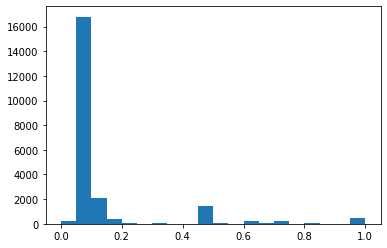

In [23]:
import matplotlib.pyplot as plt

train_proba = label_model.predict_proba(train_L)
plt.hist(train_proba[:, 1], bins=20, range=(0.0, 1.0))
plt.show()

## Part 4: Training our End Extraction Model

In this final section of the tutorial, we'll use our noisy training labels alongside the development set labels to train our end machine learning model. We start by filtering out training examples which did not recieve a label from any LF, as these examples contain no signal. Then we concatenate them with dev set examples.


In [24]:
import pandas as pd
from snorkel.analysis.utils import preds_to_probs

# Change dev labels 1D array to 2D probabilities array as required for training end model.
dev_label_probs = preds_to_probs(dev_labels, 2)
mask = train_L.max(1) != -1
combined_df = pd.concat([dev_df, train_df.iloc[mask]])
combined_proba = np.concatenate([dev_label_probs, train_proba[mask, :]], 0)

## II. Training a _Long Short-term Memory_ (LSTM) Neural Network

[LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) can acheive state-of-the-art performance on many text classification tasks. We'll train a simple LSTM model below. tf_model contains functions for processing features and building the tensorflow graphs for training and evaluation.

For this tutorial, we will be training a fairly effective deep learning model. More generally, however, Snorkel plugs in with many ML libraries, making it easy to use almost any state-of-the-art model as the end model!

In [25]:
from tf_model import get_features_and_labels, get_model

model = get_model()
tokens, idx1, idx2, label_probs = get_features_and_labels(
    combined_df, combined_proba, tf.float32
)
batch_size = 64
num_epochs = 2  # TODO: Change this to ~10. Warning: Training takes tens of minutes!
model.fit(
    (tokens, idx1, idx2),
    label_probs,
    batch_size=batch_size,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=num_epochs,
)

W0726 17:53:49.565917 139676154591040 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0726 17:53:49.656216 139676154591040 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0726 17:53:49.909171 139676154591040 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0726 17:53:49.945823 139676154591040 deprecation_wrapper.py:119] From /home/ubuntu/snorkel-tutorials/spouse/tf_model.py:46: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.



W0726 17:53:50.001340 139676154591040 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


W0726 17:53:50.728836 139676154591040 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/2


  1/347 [..............................] - ETA: 3:42 - loss: 0.6923 - acc: 0.5938

  2/347 [..............................] - ETA: 2:17 - loss: 0.6345 - acc: 0.7734

  3/347 [..............................] - ETA: 1:47 - loss: 0.5792 - acc: 0.8333

  4/347 [..............................] - ETA: 2:01 - loss: 0.5387 - acc: 0.8555

  5/347 [..............................] - ETA: 1:55 - loss: 0.4950 - acc: 0.8781

  6/347 [..............................] - ETA: 1:59 - loss: 0.4641 - acc: 0.8880

  7/347 [..............................] - ETA: 1:55 - loss: 0.4381 - acc: 0.8951

  8/347 [..............................] - ETA: 1:57 - loss: 0.4198 - acc: 0.8984

  9/347 [..............................] - ETA: 1:48 - loss: 0.4046 - acc: 0.9010

 10/347 [..............................] - ETA: 1:40 - loss: 0.3920 - acc: 0.9031

 11/347 [..............................] - ETA: 1:34 - loss: 0.3847 - acc: 0.9034

 12/347 [>.............................] - ETA: 1:29 - loss: 0.3845 - acc: 0.9010

 13/347 [>.............................] - ETA: 1:25 - loss: 0.3738 - acc: 0.9038

 14/347 [>.............................] - ETA: 1:22 - loss: 0.3616 - acc: 0.9074

 15/347 [>.............................] - ETA: 1:19 - loss: 0.3427 - acc: 0.9135

 16/347 [>.............................] - ETA: 1:16 - loss: 0.3361 - acc: 0.9150

 17/347 [>.............................] - ETA: 1:14 - loss: 0.3275 - acc: 0.9173

 18/347 [>.............................] - ETA: 1:12 - loss: 0.3274 - acc: 0.9167

 19/347 [>.............................] - ETA: 1:09 - loss: 0.3289 - acc: 0.9153

 20/347 [>.............................] - ETA: 1:08 - loss: 0.3280 - acc: 0.9148

 21/347 [>.............................] - ETA: 1:06 - loss: 0.3220 - acc: 0.9167

 22/347 [>.............................] - ETA: 1:04 - loss: 0.3216 - acc: 0.9162

 23/347 [>.............................] - ETA: 1:03 - loss: 0.3179 - acc: 0.9171

 24/347 [=>............................] - ETA: 1:01 - loss: 0.3145 - acc: 0.9180

 25/347 [=>............................] - ETA: 1:00 - loss: 0.3080 - acc: 0.9200

 26/347 [=>............................] - ETA: 58s - loss: 0.3035 - acc: 0.9213 

 27/347 [=>............................] - ETA: 59s - loss: 0.3044 - acc: 0.9207

 28/347 [=>............................] - ETA: 59s - loss: 0.3033 - acc: 0.9208

 29/347 [=>............................] - ETA: 58s - loss: 0.3037 - acc: 0.9203

 30/347 [=>............................] - ETA: 58s - loss: 0.3064 - acc: 0.9187

 31/347 [=>............................] - ETA: 57s - loss: 0.3032 - acc: 0.9199

 32/347 [=>............................] - ETA: 57s - loss: 0.3011 - acc: 0.9204

 33/347 [=>............................] - ETA: 57s - loss: 0.2979 - acc: 0.9214

 34/347 [=>............................] - ETA: 57s - loss: 0.2985 - acc: 0.9210

 35/347 [==>...........................] - ETA: 56s - loss: 0.2933 - acc: 0.9228

 36/347 [==>...........................] - ETA: 56s - loss: 0.2929 - acc: 0.9227

 37/347 [==>...........................] - ETA: 55s - loss: 0.2924 - acc: 0.9227

 38/347 [==>...........................] - ETA: 54s - loss: 0.2886 - acc: 0.9239

 39/347 [==>...........................] - ETA: 53s - loss: 0.2861 - acc: 0.9247

 40/347 [==>...........................] - ETA: 53s - loss: 0.2837 - acc: 0.9254

 41/347 [==>...........................] - ETA: 52s - loss: 0.2814 - acc: 0.9261

 42/347 [==>...........................] - ETA: 51s - loss: 0.2837 - acc: 0.9252

 43/347 [==>...........................] - ETA: 51s - loss: 0.2860 - acc: 0.9248

 44/347 [==>...........................] - ETA: 50s - loss: 0.2960 - acc: 0.9212

 45/347 [==>...........................] - ETA: 51s - loss: 0.3051 - acc: 0.9187

 46/347 [==>...........................] - ETA: 51s - loss: 0.3149 - acc: 0.9147

 47/347 [===>..........................] - ETA: 51s - loss: 0.3214 - acc: 0.9126

 48/347 [===>..........................] - ETA: 51s - loss: 0.3279 - acc: 0.9105

 49/347 [===>..........................] - ETA: 51s - loss: 0.3345 - acc: 0.9085

 50/347 [===>..........................] - ETA: 51s - loss: 0.3425 - acc: 0.9038

 51/347 [===>..........................] - ETA: 51s - loss: 0.3488 - acc: 0.9013

 52/347 [===>..........................] - ETA: 52s - loss: 0.3556 - acc: 0.8975

 53/347 [===>..........................] - ETA: 51s - loss: 0.3614 - acc: 0.8950

 54/347 [===>..........................] - ETA: 51s - loss: 0.3670 - acc: 0.8921

 55/347 [===>..........................] - ETA: 50s - loss: 0.3720 - acc: 0.8906

 56/347 [===>..........................] - ETA: 50s - loss: 0.3771 - acc: 0.8895

 57/347 [===>..........................] - ETA: 50s - loss: 0.3819 - acc: 0.8879

 58/347 [====>.........................] - ETA: 49s - loss: 0.3865 - acc: 0.8860

 59/347 [====>.........................] - ETA: 49s - loss: 0.3913 - acc: 0.8840

 60/347 [====>.........................] - ETA: 49s - loss: 0.3959 - acc: 0.8820

 61/347 [====>.........................] - ETA: 49s - loss: 0.4004 - acc: 0.8794

 62/347 [====>.........................] - ETA: 49s - loss: 0.4037 - acc: 0.8790

 63/347 [====>.........................] - ETA: 49s - loss: 0.4071 - acc: 0.8782

 64/347 [====>.........................] - ETA: 48s - loss: 0.4109 - acc: 0.8777

 65/347 [====>.........................] - ETA: 48s - loss: 0.4151 - acc: 0.8760

 66/347 [====>.........................] - ETA: 48s - loss: 0.4190 - acc: 0.8745

 67/347 [====>.........................] - ETA: 48s - loss: 0.4217 - acc: 0.8745

 68/347 [====>.........................] - ETA: 48s - loss: 0.4248 - acc: 0.8736

 69/347 [====>.........................] - ETA: 48s - loss: 0.4277 - acc: 0.8732

 70/347 [=====>........................] - ETA: 47s - loss: 0.4307 - acc: 0.8730

 71/347 [=====>........................] - ETA: 47s - loss: 0.4330 - acc: 0.8739

 72/347 [=====>........................] - ETA: 47s - loss: 0.4356 - acc: 0.8733

 73/347 [=====>........................] - ETA: 47s - loss: 0.4381 - acc: 0.8729

 74/347 [=====>........................] - ETA: 47s - loss: 0.4409 - acc: 0.8723

 75/347 [=====>........................] - ETA: 46s - loss: 0.4437 - acc: 0.8715

 76/347 [=====>........................] - ETA: 46s - loss: 0.4460 - acc: 0.8711

 77/347 [=====>........................] - ETA: 47s - loss: 0.4482 - acc: 0.8705

 78/347 [=====>........................] - ETA: 47s - loss: 0.4506 - acc: 0.8698

 79/347 [=====>........................] - ETA: 47s - loss: 0.4525 - acc: 0.8689

 80/347 [=====>........................] - ETA: 47s - loss: 0.4552 - acc: 0.8676

 81/347 [======>.......................] - ETA: 47s - loss: 0.4572 - acc: 0.8675

 82/347 [======>.......................] - ETA: 47s - loss: 0.4591 - acc: 0.8678

 83/347 [======>.......................] - ETA: 46s - loss: 0.4621 - acc: 0.8665

 84/347 [======>.......................] - ETA: 46s - loss: 0.4645 - acc: 0.8653

 85/347 [======>.......................] - ETA: 46s - loss: 0.4665 - acc: 0.8654

 86/347 [======>.......................] - ETA: 45s - loss: 0.4679 - acc: 0.8659

 87/347 [======>.......................] - ETA: 45s - loss: 0.4697 - acc: 0.8660

 88/347 [======>.......................] - ETA: 45s - loss: 0.4711 - acc: 0.8663

 89/347 [======>.......................] - ETA: 45s - loss: 0.4732 - acc: 0.8648

 90/347 [======>.......................] - ETA: 45s - loss: 0.4751 - acc: 0.8639

 91/347 [======>.......................] - ETA: 45s - loss: 0.4773 - acc: 0.8628

 92/347 [======>.......................] - ETA: 45s - loss: 0.4786 - acc: 0.8626

 93/347 [=======>......................] - ETA: 44s - loss: 0.4801 - acc: 0.8626

 94/347 [=======>......................] - ETA: 45s - loss: 0.4813 - acc: 0.8625

 95/347 [=======>......................] - ETA: 44s - loss: 0.4827 - acc: 0.8623

 96/347 [=======>......................] - ETA: 44s - loss: 0.4845 - acc: 0.8615

 97/347 [=======>......................] - ETA: 44s - loss: 0.4862 - acc: 0.8611

 98/347 [=======>......................] - ETA: 44s - loss: 0.4881 - acc: 0.8605

 99/347 [=======>......................] - ETA: 44s - loss: 0.4896 - acc: 0.8600

100/347 [=======>......................] - ETA: 44s - loss: 0.4914 - acc: 0.8591

101/347 [=======>......................] - ETA: 44s - loss: 0.4933 - acc: 0.8577

102/347 [=======>......................] - ETA: 44s - loss: 0.4949 - acc: 0.8566

103/347 [=======>......................] - ETA: 44s - loss: 0.4961 - acc: 0.8566

104/347 [=======>......................] - ETA: 44s - loss: 0.4977 - acc: 0.8553

105/347 [========>.....................] - ETA: 44s - loss: 0.4990 - acc: 0.8552

106/347 [========>.....................] - ETA: 44s - loss: 0.5005 - acc: 0.8547

107/347 [========>.....................] - ETA: 44s - loss: 0.5021 - acc: 0.8541

108/347 [========>.....................] - ETA: 44s - loss: 0.5036 - acc: 0.8539

109/347 [========>.....................] - ETA: 44s - loss: 0.5048 - acc: 0.8534

110/347 [========>.....................] - ETA: 43s - loss: 0.5065 - acc: 0.8520

111/347 [========>.....................] - ETA: 43s - loss: 0.5078 - acc: 0.8514

112/347 [========>.....................] - ETA: 43s - loss: 0.5089 - acc: 0.8513

113/347 [========>.....................] - ETA: 43s - loss: 0.5099 - acc: 0.8512

114/347 [========>.....................] - ETA: 43s - loss: 0.5106 - acc: 0.8518

115/347 [========>.....................] - ETA: 43s - loss: 0.5121 - acc: 0.8510

116/347 [=========>....................] - ETA: 42s - loss: 0.5136 - acc: 0.8502

117/347 [=========>....................] - ETA: 42s - loss: 0.5145 - acc: 0.8500

118/347 [=========>....................] - ETA: 42s - loss: 0.5154 - acc: 0.8500

119/347 [=========>....................] - ETA: 42s - loss: 0.5167 - acc: 0.8491

120/347 [=========>....................] - ETA: 41s - loss: 0.5178 - acc: 0.8486

121/347 [=========>....................] - ETA: 41s - loss: 0.5187 - acc: 0.8485

122/347 [=========>....................] - ETA: 41s - loss: 0.5195 - acc: 0.8487

123/347 [=========>....................] - ETA: 40s - loss: 0.5206 - acc: 0.8486

124/347 [=========>....................] - ETA: 40s - loss: 0.5218 - acc: 0.8480

125/347 [=========>....................] - ETA: 40s - loss: 0.5228 - acc: 0.8472

126/347 [=========>....................] - ETA: 40s - loss: 0.5239 - acc: 0.8464

127/347 [=========>....................] - ETA: 39s - loss: 0.5252 - acc: 0.8451

128/347 [==========>...................] - ETA: 39s - loss: 0.5264 - acc: 0.8444

129/347 [==========>...................] - ETA: 39s - loss: 0.5272 - acc: 0.8440

130/347 [==========>...................] - ETA: 39s - loss: 0.5279 - acc: 0.8439

131/347 [==========>...................] - ETA: 38s - loss: 0.5288 - acc: 0.8435

132/347 [==========>...................] - ETA: 38s - loss: 0.5296 - acc: 0.8433

133/347 [==========>...................] - ETA: 38s - loss: 0.5305 - acc: 0.8427

134/347 [==========>...................] - ETA: 38s - loss: 0.5307 - acc: 0.8427

135/347 [==========>...................] - ETA: 38s - loss: 0.5299 - acc: 0.8435

136/347 [==========>...................] - ETA: 37s - loss: 0.5288 - acc: 0.8443

137/347 [==========>...................] - ETA: 37s - loss: 0.5277 - acc: 0.8449

138/347 [==========>...................] - ETA: 37s - loss: 0.5262 - acc: 0.8456

139/347 [===========>..................] - ETA: 37s - loss: 0.5249 - acc: 0.8460

140/347 [===========>..................] - ETA: 38s - loss: 0.5231 - acc: 0.8468

141/347 [===========>..................] - ETA: 38s - loss: 0.5217 - acc: 0.8472

142/347 [===========>..................] - ETA: 38s - loss: 0.5200 - acc: 0.8477

143/347 [===========>..................] - ETA: 37s - loss: 0.5180 - acc: 0.8484

144/347 [===========>..................] - ETA: 37s - loss: 0.5165 - acc: 0.8488

145/347 [===========>..................] - ETA: 37s - loss: 0.5149 - acc: 0.8494

146/347 [===========>..................] - ETA: 37s - loss: 0.5137 - acc: 0.8496

147/347 [===========>..................] - ETA: 36s - loss: 0.5121 - acc: 0.8501

148/347 [===========>..................] - ETA: 36s - loss: 0.5098 - acc: 0.8509

149/347 [===========>..................] - ETA: 36s - loss: 0.5069 - acc: 0.8519

150/347 [===========>..................] - ETA: 35s - loss: 0.5054 - acc: 0.8524

151/347 [============>.................] - ETA: 35s - loss: 0.5047 - acc: 0.8525

152/347 [============>.................] - ETA: 35s - loss: 0.5032 - acc: 0.8530

153/347 [============>.................] - ETA: 35s - loss: 0.5012 - acc: 0.8537

154/347 [============>.................] - ETA: 34s - loss: 0.4997 - acc: 0.8541

155/347 [============>.................] - ETA: 34s - loss: 0.4983 - acc: 0.8545

156/347 [============>.................] - ETA: 34s - loss: 0.4966 - acc: 0.8551

157/347 [============>.................] - ETA: 33s - loss: 0.4947 - acc: 0.8557

158/347 [============>.................] - ETA: 33s - loss: 0.4927 - acc: 0.8563

159/347 [============>.................] - ETA: 33s - loss: 0.4903 - acc: 0.8571

160/347 [============>.................] - ETA: 33s - loss: 0.4890 - acc: 0.8575

161/347 [============>.................] - ETA: 33s - loss: 0.4880 - acc: 0.8578

162/347 [=============>................] - ETA: 32s - loss: 0.4869 - acc: 0.8581

163/347 [=============>................] - ETA: 32s - loss: 0.4863 - acc: 0.8582

164/347 [=============>................] - ETA: 32s - loss: 0.4852 - acc: 0.8585

165/347 [=============>................] - ETA: 32s - loss: 0.4839 - acc: 0.8589

166/347 [=============>................] - ETA: 32s - loss: 0.4825 - acc: 0.8594

167/347 [=============>................] - ETA: 31s - loss: 0.4808 - acc: 0.8599

168/347 [=============>................] - ETA: 31s - loss: 0.4791 - acc: 0.8605

169/347 [=============>................] - ETA: 31s - loss: 0.4779 - acc: 0.8609

170/347 [=============>................] - ETA: 31s - loss: 0.4767 - acc: 0.8612

171/347 [=============>................] - ETA: 31s - loss: 0.4748 - acc: 0.8618

172/347 [=============>................] - ETA: 30s - loss: 0.4731 - acc: 0.8624

173/347 [=============>................] - ETA: 30s - loss: 0.4712 - acc: 0.8630

174/347 [==============>...............] - ETA: 30s - loss: 0.4699 - acc: 0.8634

175/347 [==============>...............] - ETA: 30s - loss: 0.4688 - acc: 0.8637

176/347 [==============>...............] - ETA: 29s - loss: 0.4681 - acc: 0.8640

177/347 [==============>...............] - ETA: 29s - loss: 0.4687 - acc: 0.8640

178/347 [==============>...............] - ETA: 29s - loss: 0.4704 - acc: 0.8635

179/347 [==============>...............] - ETA: 29s - loss: 0.4722 - acc: 0.8626

180/347 [==============>...............] - ETA: 29s - loss: 0.4730 - acc: 0.8624

181/347 [==============>...............] - ETA: 29s - loss: 0.4742 - acc: 0.8620

182/347 [==============>...............] - ETA: 28s - loss: 0.4752 - acc: 0.8617

183/347 [==============>...............] - ETA: 28s - loss: 0.4763 - acc: 0.8614

184/347 [==============>...............] - ETA: 28s - loss: 0.4776 - acc: 0.8609

185/347 [==============>...............] - ETA: 28s - loss: 0.4786 - acc: 0.8605

186/347 [===============>..............] - ETA: 28s - loss: 0.4797 - acc: 0.8596

187/347 [===============>..............] - ETA: 28s - loss: 0.4805 - acc: 0.8592

188/347 [===============>..............] - ETA: 27s - loss: 0.4815 - acc: 0.8588

189/347 [===============>..............] - ETA: 27s - loss: 0.4825 - acc: 0.8582

190/347 [===============>..............] - ETA: 27s - loss: 0.4835 - acc: 0.8577

191/347 [===============>..............] - ETA: 27s - loss: 0.4844 - acc: 0.8575

192/347 [===============>..............] - ETA: 27s - loss: 0.4855 - acc: 0.8565

193/347 [===============>..............] - ETA: 26s - loss: 0.4864 - acc: 0.8562

194/347 [===============>..............] - ETA: 26s - loss: 0.4872 - acc: 0.8561

195/347 [===============>..............] - ETA: 26s - loss: 0.4882 - acc: 0.8554

196/347 [===============>..............] - ETA: 26s - loss: 0.4889 - acc: 0.8553

197/347 [================>.............] - ETA: 26s - loss: 0.4896 - acc: 0.8551

198/347 [================>.............] - ETA: 26s - loss: 0.4902 - acc: 0.8550

199/347 [================>.............] - ETA: 25s - loss: 0.4911 - acc: 0.8549

200/347 [================>.............] - ETA: 25s - loss: 0.4917 - acc: 0.8549

201/347 [================>.............] - ETA: 25s - loss: 0.4923 - acc: 0.8551

202/347 [================>.............] - ETA: 25s - loss: 0.4930 - acc: 0.8551

203/347 [================>.............] - ETA: 25s - loss: 0.4936 - acc: 0.8551

204/347 [================>.............] - ETA: 25s - loss: 0.4943 - acc: 0.8549

205/347 [================>.............] - ETA: 24s - loss: 0.4951 - acc: 0.8546

206/347 [================>.............] - ETA: 24s - loss: 0.4959 - acc: 0.8544

207/347 [================>.............] - ETA: 24s - loss: 0.4965 - acc: 0.8542

208/347 [================>.............] - ETA: 24s - loss: 0.4971 - acc: 0.8543

209/347 [=================>............] - ETA: 24s - loss: 0.4978 - acc: 0.8543

210/347 [=================>............] - ETA: 24s - loss: 0.4982 - acc: 0.8542

211/347 [=================>............] - ETA: 24s - loss: 0.4988 - acc: 0.8540

212/347 [=================>............] - ETA: 23s - loss: 0.4993 - acc: 0.8539

213/347 [=================>............] - ETA: 23s - loss: 0.5001 - acc: 0.8534

214/347 [=================>............] - ETA: 23s - loss: 0.5007 - acc: 0.8535

215/347 [=================>............] - ETA: 23s - loss: 0.5012 - acc: 0.8536

216/347 [=================>............] - ETA: 23s - loss: 0.5020 - acc: 0.8537

217/347 [=================>............] - ETA: 23s - loss: 0.5025 - acc: 0.8535

218/347 [=================>............] - ETA: 22s - loss: 0.5034 - acc: 0.8530

219/347 [=================>............] - ETA: 22s - loss: 0.5040 - acc: 0.8527

220/347 [==================>...........] - ETA: 22s - loss: 0.5046 - acc: 0.8525

221/347 [==================>...........] - ETA: 22s - loss: 0.5052 - acc: 0.8523

222/347 [==================>...........] - ETA: 22s - loss: 0.5058 - acc: 0.8521

223/347 [==================>...........] - ETA: 21s - loss: 0.5063 - acc: 0.8522

224/347 [==================>...........] - ETA: 21s - loss: 0.5068 - acc: 0.8521

225/347 [==================>...........] - ETA: 21s - loss: 0.5072 - acc: 0.8521

226/347 [==================>...........] - ETA: 21s - loss: 0.5076 - acc: 0.8522

227/347 [==================>...........] - ETA: 21s - loss: 0.5080 - acc: 0.8523

228/347 [==================>...........] - ETA: 21s - loss: 0.5088 - acc: 0.8516

229/347 [==================>...........] - ETA: 20s - loss: 0.5093 - acc: 0.8515

230/347 [==================>...........] - ETA: 20s - loss: 0.5098 - acc: 0.8515

231/347 [==================>...........] - ETA: 20s - loss: 0.5106 - acc: 0.8511

232/347 [===================>..........] - ETA: 20s - loss: 0.5112 - acc: 0.8510

233/347 [===================>..........] - ETA: 20s - loss: 0.5116 - acc: 0.8511

234/347 [===================>..........] - ETA: 20s - loss: 0.5123 - acc: 0.8506

235/347 [===================>..........] - ETA: 20s - loss: 0.5130 - acc: 0.8501

236/347 [===================>..........] - ETA: 20s - loss: 0.5136 - acc: 0.8498

237/347 [===================>..........] - ETA: 19s - loss: 0.5141 - acc: 0.8496

238/347 [===================>..........] - ETA: 19s - loss: 0.5146 - acc: 0.8497

239/347 [===================>..........] - ETA: 19s - loss: 0.5151 - acc: 0.8495

240/347 [===================>..........] - ETA: 19s - loss: 0.5158 - acc: 0.8489

241/347 [===================>..........] - ETA: 19s - loss: 0.5166 - acc: 0.8485

242/347 [===================>..........] - ETA: 19s - loss: 0.5172 - acc: 0.8481

243/347 [====================>.........] - ETA: 18s - loss: 0.5178 - acc: 0.8479

244/347 [====================>.........] - ETA: 18s - loss: 0.5184 - acc: 0.8479

245/347 [====================>.........] - ETA: 18s - loss: 0.5188 - acc: 0.8478

246/347 [====================>.........] - ETA: 18s - loss: 0.5192 - acc: 0.8479

247/347 [====================>.........] - ETA: 18s - loss: 0.5196 - acc: 0.8479

248/347 [====================>.........] - ETA: 17s - loss: 0.5201 - acc: 0.8480

249/347 [====================>.........] - ETA: 17s - loss: 0.5207 - acc: 0.8477

250/347 [====================>.........] - ETA: 17s - loss: 0.5212 - acc: 0.8474

251/347 [====================>.........] - ETA: 17s - loss: 0.5217 - acc: 0.8472

252/347 [====================>.........] - ETA: 17s - loss: 0.5220 - acc: 0.8472

253/347 [====================>.........] - ETA: 16s - loss: 0.5224 - acc: 0.8471

254/347 [====================>.........] - ETA: 16s - loss: 0.5230 - acc: 0.8469

255/347 [=====================>........] - ETA: 16s - loss: 0.5235 - acc: 0.8463

256/347 [=====================>........] - ETA: 16s - loss: 0.5239 - acc: 0.8464

257/347 [=====================>........] - ETA: 16s - loss: 0.5243 - acc: 0.8464

258/347 [=====================>........] - ETA: 15s - loss: 0.5249 - acc: 0.8461

259/347 [=====================>........] - ETA: 15s - loss: 0.5253 - acc: 0.8460

260/347 [=====================>........] - ETA: 15s - loss: 0.5260 - acc: 0.8455

261/347 [=====================>........] - ETA: 15s - loss: 0.5264 - acc: 0.8451

262/347 [=====================>........] - ETA: 15s - loss: 0.5270 - acc: 0.8447

263/347 [=====================>........] - ETA: 15s - loss: 0.5273 - acc: 0.8447

264/347 [=====================>........] - ETA: 14s - loss: 0.5277 - acc: 0.8445

265/347 [=====================>........] - ETA: 14s - loss: 0.5282 - acc: 0.8440

266/347 [=====================>........] - ETA: 14s - loss: 0.5286 - acc: 0.8442

267/347 [======================>.......] - ETA: 14s - loss: 0.5291 - acc: 0.8436

268/347 [======================>.......] - ETA: 14s - loss: 0.5289 - acc: 0.8440

269/347 [======================>.......] - ETA: 13s - loss: 0.5285 - acc: 0.8443

270/347 [======================>.......] - ETA: 13s - loss: 0.5280 - acc: 0.8447

271/347 [======================>.......] - ETA: 13s - loss: 0.5275 - acc: 0.8449

272/347 [======================>.......] - ETA: 13s - loss: 0.5266 - acc: 0.8454

273/347 [======================>.......] - ETA: 13s - loss: 0.5260 - acc: 0.8456

274/347 [======================>.......] - ETA: 13s - loss: 0.5251 - acc: 0.8460

275/347 [======================>.......] - ETA: 13s - loss: 0.5241 - acc: 0.8464

276/347 [======================>.......] - ETA: 12s - loss: 0.5234 - acc: 0.8466

277/347 [======================>.......] - ETA: 12s - loss: 0.5228 - acc: 0.8467

278/347 [=======================>......] - ETA: 12s - loss: 0.5218 - acc: 0.8471

279/347 [=======================>......] - ETA: 12s - loss: 0.5209 - acc: 0.8474

280/347 [=======================>......] - ETA: 12s - loss: 0.5202 - acc: 0.8476

281/347 [=======================>......] - ETA: 11s - loss: 0.5191 - acc: 0.8480

282/347 [=======================>......] - ETA: 11s - loss: 0.5183 - acc: 0.8482

283/347 [=======================>......] - ETA: 11s - loss: 0.5172 - acc: 0.8486

284/347 [=======================>......] - ETA: 11s - loss: 0.5160 - acc: 0.8490

285/347 [=======================>......] - ETA: 11s - loss: 0.5155 - acc: 0.8491

286/347 [=======================>......] - ETA: 10s - loss: 0.5149 - acc: 0.8492

287/347 [=======================>......] - ETA: 10s - loss: 0.5138 - acc: 0.8496

288/347 [=======================>......] - ETA: 10s - loss: 0.5130 - acc: 0.8498

289/347 [=======================>......] - ETA: 10s - loss: 0.5119 - acc: 0.8502

290/347 [========================>.....] - ETA: 10s - loss: 0.5111 - acc: 0.8504

291/347 [========================>.....] - ETA: 10s - loss: 0.5100 - acc: 0.8508

292/347 [========================>.....] - ETA: 9s - loss: 0.5093 - acc: 0.8510 

293/347 [========================>.....] - ETA: 9s - loss: 0.5080 - acc: 0.8514

294/347 [========================>.....] - ETA: 9s - loss: 0.5075 - acc: 0.8516

295/347 [========================>.....] - ETA: 9s - loss: 0.5067 - acc: 0.8518

296/347 [========================>.....] - ETA: 9s - loss: 0.5061 - acc: 0.8520

297/347 [========================>.....] - ETA: 8s - loss: 0.5053 - acc: 0.8522

298/347 [========================>.....] - ETA: 8s - loss: 0.5045 - acc: 0.8525

299/347 [========================>.....] - ETA: 8s - loss: 0.5037 - acc: 0.8527

300/347 [========================>.....] - ETA: 8s - loss: 0.5026 - acc: 0.8531

301/347 [=========================>....] - ETA: 8s - loss: 0.5014 - acc: 0.8535

302/347 [=========================>....] - ETA: 7s - loss: 0.5008 - acc: 0.8536

303/347 [=========================>....] - ETA: 7s - loss: 0.5006 - acc: 0.8537

304/347 [=========================>....] - ETA: 7s - loss: 0.4993 - acc: 0.8541

305/347 [=========================>....] - ETA: 7s - loss: 0.4980 - acc: 0.8546

306/347 [=========================>....] - ETA: 7s - loss: 0.4971 - acc: 0.8548

307/347 [=========================>....] - ETA: 7s - loss: 0.4960 - acc: 0.8552

308/347 [=========================>....] - ETA: 6s - loss: 0.4950 - acc: 0.8555

309/347 [=========================>....] - ETA: 6s - loss: 0.4944 - acc: 0.8557

310/347 [=========================>....] - ETA: 6s - loss: 0.4944 - acc: 0.8557

311/347 [=========================>....] - ETA: 6s - loss: 0.4953 - acc: 0.8554

312/347 [=========================>....] - ETA: 6s - loss: 0.4960 - acc: 0.8552

313/347 [==========================>...] - ETA: 5s - loss: 0.4969 - acc: 0.8548

314/347 [==========================>...] - ETA: 5s - loss: 0.4975 - acc: 0.8547

315/347 [==========================>...] - ETA: 5s - loss: 0.4981 - acc: 0.8545

316/347 [==========================>...] - ETA: 5s - loss: 0.4985 - acc: 0.8544

317/347 [==========================>...] - ETA: 5s - loss: 0.4992 - acc: 0.8542

318/347 [==========================>...] - ETA: 5s - loss: 0.4998 - acc: 0.8538

319/347 [==========================>...] - ETA: 4s - loss: 0.5003 - acc: 0.8535

320/347 [==========================>...] - ETA: 4s - loss: 0.5009 - acc: 0.8530

321/347 [==========================>...] - ETA: 4s - loss: 0.5015 - acc: 0.8526

322/347 [==========================>...] - ETA: 4s - loss: 0.5018 - acc: 0.8527

323/347 [==========================>...] - ETA: 4s - loss: 0.5023 - acc: 0.8527

324/347 [===========================>..] - ETA: 4s - loss: 0.5028 - acc: 0.8523

325/347 [===========================>..] - ETA: 3s - loss: 0.5033 - acc: 0.8519

326/347 [===========================>..] - ETA: 3s - loss: 0.5039 - acc: 0.8516

327/347 [===========================>..] - ETA: 3s - loss: 0.5044 - acc: 0.8513

328/347 [===========================>..] - ETA: 3s - loss: 0.5049 - acc: 0.8509

329/347 [===========================>..] - ETA: 3s - loss: 0.5052 - acc: 0.8510

330/347 [===========================>..] - ETA: 2s - loss: 0.5057 - acc: 0.8508

331/347 [===========================>..] - ETA: 2s - loss: 0.5060 - acc: 0.8509

332/347 [===========================>..] - ETA: 2s - loss: 0.5064 - acc: 0.8509

333/347 [===========================>..] - ETA: 2s - loss: 0.5069 - acc: 0.8506

334/347 [===========================>..] - ETA: 2s - loss: 0.5073 - acc: 0.8505

335/347 [===========================>..] - ETA: 2s - loss: 0.5076 - acc: 0.8504

336/347 [============================>.] - ETA: 1s - loss: 0.5080 - acc: 0.8505

337/347 [============================>.] - ETA: 1s - loss: 0.5083 - acc: 0.8506

338/347 [============================>.] - ETA: 1s - loss: 0.5085 - acc: 0.8507

339/347 [============================>.] - ETA: 1s - loss: 0.5089 - acc: 0.8507

340/347 [============================>.] - ETA: 1s - loss: 0.5093 - acc: 0.8506

341/347 [============================>.] - ETA: 1s - loss: 0.5096 - acc: 0.8506

342/347 [============================>.] - ETA: 0s - loss: 0.5100 - acc: 0.8506

343/347 [============================>.] - ETA: 0s - loss: 0.5103 - acc: 0.8508

344/347 [============================>.] - ETA: 0s - loss: 0.5106 - acc: 0.8508

345/347 [============================>.] - ETA: 0s - loss: 0.5110 - acc: 0.8505

346/347 [============================>.] - ETA: 0s - loss: 0.5114 - acc: 0.8503

347/347 [==============================] - 61s 177ms/step - loss: 0.5117 - acc: 0.8501


Epoch 2/2


  1/347 [..............................] - ETA: 1:52 - loss: 0.6054 - acc: 0.8906

  2/347 [..............................] - ETA: 1:20 - loss: 0.6193 - acc: 0.8438

  3/347 [..............................] - ETA: 1:06 - loss: 0.6446 - acc: 0.8177

  4/347 [..............................] - ETA: 1:01 - loss: 0.6414 - acc: 0.8281

  5/347 [..............................] - ETA: 58s - loss: 0.6331 - acc: 0.8469 

  6/347 [..............................] - ETA: 55s - loss: 0.6313 - acc: 0.8411

  7/347 [..............................] - ETA: 53s - loss: 0.6364 - acc: 0.8326

  8/347 [..............................] - ETA: 57s - loss: 0.6401 - acc: 0.8301

  9/347 [..............................] - ETA: 1:01 - loss: 0.6378 - acc: 0.8281

 10/347 [..............................] - ETA: 1:03 - loss: 0.6345 - acc: 0.8328

 11/347 [..............................] - ETA: 1:05 - loss: 0.6344 - acc: 0.8324

 12/347 [>.............................] - ETA: 1:03 - loss: 0.6322 - acc: 0.8346

 13/347 [>.............................] - ETA: 1:05 - loss: 0.6305 - acc: 0.8365

 14/347 [>.............................] - ETA: 1:04 - loss: 0.6295 - acc: 0.8359

 15/347 [>.............................] - ETA: 1:04 - loss: 0.6311 - acc: 0.8313

 16/347 [>.............................] - ETA: 1:05 - loss: 0.6321 - acc: 0.8252

 17/347 [>.............................] - ETA: 1:06 - loss: 0.6298 - acc: 0.8300

 18/347 [>.............................] - ETA: 1:06 - loss: 0.6322 - acc: 0.8264

 19/347 [>.............................] - ETA: 1:07 - loss: 0.6352 - acc: 0.8215

 20/347 [>.............................] - ETA: 1:07 - loss: 0.6357 - acc: 0.8219

 21/347 [>.............................] - ETA: 1:09 - loss: 0.6371 - acc: 0.8199

 22/347 [>.............................] - ETA: 1:08 - loss: 0.6381 - acc: 0.8175

 23/347 [>.............................] - ETA: 1:08 - loss: 0.6392 - acc: 0.8152

 24/347 [=>............................] - ETA: 1:08 - loss: 0.6392 - acc: 0.8158

 25/347 [=>............................] - ETA: 1:10 - loss: 0.6389 - acc: 0.8150

 26/347 [=>............................] - ETA: 1:09 - loss: 0.6401 - acc: 0.8131

 27/347 [=>............................] - ETA: 1:09 - loss: 0.6406 - acc: 0.8137

 28/347 [=>............................] - ETA: 1:08 - loss: 0.6419 - acc: 0.8114

 29/347 [=>............................] - ETA: 1:07 - loss: 0.6423 - acc: 0.8114

 30/347 [=>............................] - ETA: 1:07 - loss: 0.6430 - acc: 0.8089

 31/347 [=>............................] - ETA: 1:07 - loss: 0.6429 - acc: 0.8105

 32/347 [=>............................] - ETA: 1:07 - loss: 0.6418 - acc: 0.8135

 33/347 [=>............................] - ETA: 1:06 - loss: 0.6405 - acc: 0.8158

 34/347 [=>............................] - ETA: 1:06 - loss: 0.6410 - acc: 0.8153

 35/347 [==>...........................] - ETA: 1:05 - loss: 0.6415 - acc: 0.8138

 36/347 [==>...........................] - ETA: 1:04 - loss: 0.6420 - acc: 0.8121

 37/347 [==>...........................] - ETA: 1:04 - loss: 0.6413 - acc: 0.8133

 38/347 [==>...........................] - ETA: 1:03 - loss: 0.6409 - acc: 0.8129

 39/347 [==>...........................] - ETA: 1:02 - loss: 0.6408 - acc: 0.8133

 40/347 [==>...........................] - ETA: 1:02 - loss: 0.6414 - acc: 0.8125

 41/347 [==>...........................] - ETA: 1:01 - loss: 0.6415 - acc: 0.8136

 42/347 [==>...........................] - ETA: 1:00 - loss: 0.6424 - acc: 0.8118

 43/347 [==>...........................] - ETA: 59s - loss: 0.6418 - acc: 0.8125 

 44/347 [==>...........................] - ETA: 59s - loss: 0.6422 - acc: 0.8111

 45/347 [==>...........................] - ETA: 58s - loss: 0.6429 - acc: 0.8101

 46/347 [==>...........................] - ETA: 58s - loss: 0.6429 - acc: 0.8101

 47/347 [===>..........................] - ETA: 57s - loss: 0.6432 - acc: 0.8092

 48/347 [===>..........................] - ETA: 57s - loss: 0.6439 - acc: 0.8070

 49/347 [===>..........................] - ETA: 56s - loss: 0.6437 - acc: 0.8055

 50/347 [===>..........................] - ETA: 56s - loss: 0.6440 - acc: 0.8041

 51/347 [===>..........................] - ETA: 56s - loss: 0.6438 - acc: 0.8045

 52/347 [===>..........................] - ETA: 56s - loss: 0.6434 - acc: 0.8053

 53/347 [===>..........................] - ETA: 55s - loss: 0.6436 - acc: 0.8051

 54/347 [===>..........................] - ETA: 55s - loss: 0.6420 - acc: 0.8056

 55/347 [===>..........................] - ETA: 54s - loss: 0.6385 - acc: 0.8080

 56/347 [===>..........................] - ETA: 54s - loss: 0.6344 - acc: 0.8103

 57/347 [===>..........................] - ETA: 55s - loss: 0.6302 - acc: 0.8122

 58/347 [====>.........................] - ETA: 56s - loss: 0.6255 - acc: 0.8144

 59/347 [====>.........................] - ETA: 57s - loss: 0.6206 - acc: 0.8165

 60/347 [====>.........................] - ETA: 57s - loss: 0.6158 - acc: 0.8182

 61/347 [====>.........................] - ETA: 57s - loss: 0.6114 - acc: 0.8197

 62/347 [====>.........................] - ETA: 56s - loss: 0.6066 - acc: 0.8213

 63/347 [====>.........................] - ETA: 56s - loss: 0.6010 - acc: 0.8234

 64/347 [====>.........................] - ETA: 55s - loss: 0.5958 - acc: 0.8252

 65/347 [====>.........................] - ETA: 54s - loss: 0.5906 - acc: 0.8269

 66/347 [====>.........................] - ETA: 54s - loss: 0.5846 - acc: 0.8291

 67/347 [====>.........................] - ETA: 53s - loss: 0.5795 - acc: 0.8307

 68/347 [====>.........................] - ETA: 53s - loss: 0.5745 - acc: 0.8323

 69/347 [====>.........................] - ETA: 52s - loss: 0.5717 - acc: 0.8329

 70/347 [=====>........................] - ETA: 52s - loss: 0.5655 - acc: 0.8350

 71/347 [=====>........................] - ETA: 52s - loss: 0.5619 - acc: 0.8360

 72/347 [=====>........................] - ETA: 51s - loss: 0.5595 - acc: 0.8366

 73/347 [=====>........................] - ETA: 51s - loss: 0.5560 - acc: 0.8375

 74/347 [=====>........................] - ETA: 50s - loss: 0.5517 - acc: 0.8389

 75/347 [=====>........................] - ETA: 50s - loss: 0.5470 - acc: 0.8404

 76/347 [=====>........................] - ETA: 49s - loss: 0.5419 - acc: 0.8421

 77/347 [=====>........................] - ETA: 49s - loss: 0.5384 - acc: 0.8431

 78/347 [=====>........................] - ETA: 48s - loss: 0.5350 - acc: 0.8442

 79/347 [=====>........................] - ETA: 48s - loss: 0.5312 - acc: 0.8453

 80/347 [=====>........................] - ETA: 47s - loss: 0.5285 - acc: 0.8461

 81/347 [======>.......................] - ETA: 47s - loss: 0.5254 - acc: 0.8470

 82/347 [======>.......................] - ETA: 47s - loss: 0.5218 - acc: 0.8481

 83/347 [======>.......................] - ETA: 47s - loss: 0.5197 - acc: 0.8486

 84/347 [======>.......................] - ETA: 47s - loss: 0.5182 - acc: 0.8490

 85/347 [======>.......................] - ETA: 46s - loss: 0.5144 - acc: 0.8502

 86/347 [======>.......................] - ETA: 46s - loss: 0.5103 - acc: 0.8516

 87/347 [======>.......................] - ETA: 46s - loss: 0.5076 - acc: 0.8524

 88/347 [======>.......................] - ETA: 46s - loss: 0.5045 - acc: 0.8533

 89/347 [======>.......................] - ETA: 45s - loss: 0.5006 - acc: 0.8546

 90/347 [======>.......................] - ETA: 45s - loss: 0.4976 - acc: 0.8556

 91/347 [======>.......................] - ETA: 45s - loss: 0.4938 - acc: 0.8568

 92/347 [======>.......................] - ETA: 44s - loss: 0.4914 - acc: 0.8575

 93/347 [=======>......................] - ETA: 44s - loss: 0.4882 - acc: 0.8585

 94/347 [=======>......................] - ETA: 44s - loss: 0.4850 - acc: 0.8595

 95/347 [=======>......................] - ETA: 43s - loss: 0.4828 - acc: 0.8602

 96/347 [=======>......................] - ETA: 43s - loss: 0.4805 - acc: 0.8608

 97/347 [=======>......................] - ETA: 43s - loss: 0.4825 - acc: 0.8603

 98/347 [=======>......................] - ETA: 42s - loss: 0.4864 - acc: 0.8592

 99/347 [=======>......................] - ETA: 42s - loss: 0.4885 - acc: 0.8589

100/347 [=======>......................] - ETA: 42s - loss: 0.4899 - acc: 0.8586

101/347 [=======>......................] - ETA: 42s - loss: 0.4920 - acc: 0.8574

102/347 [=======>......................] - ETA: 42s - loss: 0.4934 - acc: 0.8571

103/347 [=======>......................] - ETA: 42s - loss: 0.4960 - acc: 0.8560

104/347 [=======>......................] - ETA: 42s - loss: 0.4979 - acc: 0.8553

105/347 [========>.....................] - ETA: 42s - loss: 0.5001 - acc: 0.8542

106/347 [========>.....................] - ETA: 41s - loss: 0.5021 - acc: 0.8532

107/347 [========>.....................] - ETA: 41s - loss: 0.5035 - acc: 0.8527

108/347 [========>.....................] - ETA: 41s - loss: 0.5046 - acc: 0.8524

109/347 [========>.....................] - ETA: 41s - loss: 0.5062 - acc: 0.8519

110/347 [========>.....................] - ETA: 41s - loss: 0.5077 - acc: 0.8509

111/347 [========>.....................] - ETA: 40s - loss: 0.5094 - acc: 0.8499

112/347 [========>.....................] - ETA: 40s - loss: 0.5108 - acc: 0.8489

113/347 [========>.....................] - ETA: 40s - loss: 0.5121 - acc: 0.8487

114/347 [========>.....................] - ETA: 40s - loss: 0.5135 - acc: 0.8477

115/347 [========>.....................] - ETA: 40s - loss: 0.5153 - acc: 0.8459

116/347 [=========>....................] - ETA: 39s - loss: 0.5162 - acc: 0.8459

117/347 [=========>....................] - ETA: 39s - loss: 0.5170 - acc: 0.8460

118/347 [=========>....................] - ETA: 39s - loss: 0.5178 - acc: 0.8464

119/347 [=========>....................] - ETA: 39s - loss: 0.5191 - acc: 0.8461

120/347 [=========>....................] - ETA: 39s - loss: 0.5200 - acc: 0.8460

121/347 [=========>....................] - ETA: 39s - loss: 0.5206 - acc: 0.8463

122/347 [=========>....................] - ETA: 38s - loss: 0.5218 - acc: 0.8454

123/347 [=========>....................] - ETA: 38s - loss: 0.5227 - acc: 0.8453

124/347 [=========>....................] - ETA: 38s - loss: 0.5232 - acc: 0.8459

125/347 [=========>....................] - ETA: 38s - loss: 0.5240 - acc: 0.8461

126/347 [=========>....................] - ETA: 38s - loss: 0.5245 - acc: 0.8469

127/347 [=========>....................] - ETA: 37s - loss: 0.5252 - acc: 0.8468

128/347 [==========>...................] - ETA: 37s - loss: 0.5262 - acc: 0.8466

129/347 [==========>...................] - ETA: 38s - loss: 0.5274 - acc: 0.8461

130/347 [==========>...................] - ETA: 37s - loss: 0.5279 - acc: 0.8464

131/347 [==========>...................] - ETA: 37s - loss: 0.5290 - acc: 0.8452

132/347 [==========>...................] - ETA: 37s - loss: 0.5295 - acc: 0.8454

133/347 [==========>...................] - ETA: 37s - loss: 0.5306 - acc: 0.8445

134/347 [==========>...................] - ETA: 37s - loss: 0.5314 - acc: 0.8438

135/347 [==========>...................] - ETA: 37s - loss: 0.5320 - acc: 0.8441

136/347 [==========>...................] - ETA: 36s - loss: 0.5327 - acc: 0.8448

137/347 [==========>...................] - ETA: 36s - loss: 0.5339 - acc: 0.8442

138/347 [==========>...................] - ETA: 36s - loss: 0.5347 - acc: 0.8441

139/347 [===========>..................] - ETA: 36s - loss: 0.5350 - acc: 0.8446

140/347 [===========>..................] - ETA: 36s - loss: 0.5354 - acc: 0.8449

141/347 [===========>..................] - ETA: 35s - loss: 0.5363 - acc: 0.8442

142/347 [===========>..................] - ETA: 35s - loss: 0.5367 - acc: 0.8443

143/347 [===========>..................] - ETA: 35s - loss: 0.5375 - acc: 0.8439

144/347 [===========>..................] - ETA: 35s - loss: 0.5382 - acc: 0.8435

145/347 [===========>..................] - ETA: 35s - loss: 0.5388 - acc: 0.8436

146/347 [===========>..................] - ETA: 35s - loss: 0.5393 - acc: 0.8439

147/347 [===========>..................] - ETA: 34s - loss: 0.5400 - acc: 0.8436

148/347 [===========>..................] - ETA: 34s - loss: 0.5405 - acc: 0.8434

149/347 [===========>..................] - ETA: 34s - loss: 0.5411 - acc: 0.8433

150/347 [===========>..................] - ETA: 34s - loss: 0.5419 - acc: 0.8430

151/347 [============>.................] - ETA: 34s - loss: 0.5426 - acc: 0.8427

152/347 [============>.................] - ETA: 34s - loss: 0.5434 - acc: 0.8426

153/347 [============>.................] - ETA: 34s - loss: 0.5443 - acc: 0.8419

154/347 [============>.................] - ETA: 34s - loss: 0.5450 - acc: 0.8415

155/347 [============>.................] - ETA: 34s - loss: 0.5456 - acc: 0.8410

156/347 [============>.................] - ETA: 34s - loss: 0.5463 - acc: 0.8403

157/347 [============>.................] - ETA: 34s - loss: 0.5468 - acc: 0.8404

158/347 [============>.................] - ETA: 33s - loss: 0.5473 - acc: 0.8406

159/347 [============>.................] - ETA: 33s - loss: 0.5480 - acc: 0.8403

160/347 [============>.................] - ETA: 33s - loss: 0.5489 - acc: 0.8396

161/347 [============>.................] - ETA: 33s - loss: 0.5495 - acc: 0.8393

162/347 [=============>................] - ETA: 33s - loss: 0.5503 - acc: 0.8390

163/347 [=============>................] - ETA: 33s - loss: 0.5510 - acc: 0.8387

164/347 [=============>................] - ETA: 33s - loss: 0.5519 - acc: 0.8377

165/347 [=============>................] - ETA: 32s - loss: 0.5522 - acc: 0.8381

166/347 [=============>................] - ETA: 32s - loss: 0.5527 - acc: 0.8380

167/347 [=============>................] - ETA: 32s - loss: 0.5531 - acc: 0.8381

168/347 [=============>................] - ETA: 32s - loss: 0.5537 - acc: 0.8380

169/347 [=============>................] - ETA: 32s - loss: 0.5543 - acc: 0.8376

170/347 [=============>................] - ETA: 31s - loss: 0.5549 - acc: 0.8373

171/347 [=============>................] - ETA: 31s - loss: 0.5553 - acc: 0.8370

172/347 [=============>................] - ETA: 31s - loss: 0.5558 - acc: 0.8369

173/347 [=============>................] - ETA: 31s - loss: 0.5562 - acc: 0.8372

174/347 [==============>...............] - ETA: 30s - loss: 0.5567 - acc: 0.8368

175/347 [==============>...............] - ETA: 30s - loss: 0.5572 - acc: 0.8366

176/347 [==============>...............] - ETA: 30s - loss: 0.5577 - acc: 0.8363

177/347 [==============>...............] - ETA: 30s - loss: 0.5581 - acc: 0.8364

178/347 [==============>...............] - ETA: 30s - loss: 0.5588 - acc: 0.8358

179/347 [==============>...............] - ETA: 29s - loss: 0.5592 - acc: 0.8355

180/347 [==============>...............] - ETA: 29s - loss: 0.5600 - acc: 0.8350

181/347 [==============>...............] - ETA: 29s - loss: 0.5604 - acc: 0.8349

182/347 [==============>...............] - ETA: 29s - loss: 0.5609 - acc: 0.8346

183/347 [==============>...............] - ETA: 29s - loss: 0.5613 - acc: 0.8343

184/347 [==============>...............] - ETA: 28s - loss: 0.5617 - acc: 0.8341

185/347 [==============>...............] - ETA: 28s - loss: 0.5621 - acc: 0.8340

186/347 [===============>..............] - ETA: 28s - loss: 0.5625 - acc: 0.8336

187/347 [===============>..............] - ETA: 28s - loss: 0.5630 - acc: 0.8333

188/347 [===============>..............] - ETA: 28s - loss: 0.5625 - acc: 0.8338

189/347 [===============>..............] - ETA: 27s - loss: 0.5619 - acc: 0.8342

190/347 [===============>..............] - ETA: 27s - loss: 0.5611 - acc: 0.8347

191/347 [===============>..............] - ETA: 27s - loss: 0.5602 - acc: 0.8352

192/347 [===============>..............] - ETA: 27s - loss: 0.5590 - acc: 0.8359

193/347 [===============>..............] - ETA: 27s - loss: 0.5580 - acc: 0.8363

194/347 [===============>..............] - ETA: 27s - loss: 0.5569 - acc: 0.8367

195/347 [===============>..............] - ETA: 27s - loss: 0.5555 - acc: 0.8373

196/347 [===============>..............] - ETA: 27s - loss: 0.5542 - acc: 0.8379

197/347 [================>.............] - ETA: 27s - loss: 0.5529 - acc: 0.8383

198/347 [================>.............] - ETA: 27s - loss: 0.5518 - acc: 0.8386

199/347 [================>.............] - ETA: 26s - loss: 0.5504 - acc: 0.8391

200/347 [================>.............] - ETA: 26s - loss: 0.5489 - acc: 0.8396

201/347 [================>.............] - ETA: 26s - loss: 0.5476 - acc: 0.8400

202/347 [================>.............] - ETA: 26s - loss: 0.5463 - acc: 0.8404

203/347 [================>.............] - ETA: 26s - loss: 0.5448 - acc: 0.8409

204/347 [================>.............] - ETA: 25s - loss: 0.5428 - acc: 0.8416

205/347 [================>.............] - ETA: 25s - loss: 0.5419 - acc: 0.8418

206/347 [================>.............] - ETA: 25s - loss: 0.5409 - acc: 0.8421

207/347 [================>.............] - ETA: 25s - loss: 0.5398 - acc: 0.8424

208/347 [================>.............] - ETA: 24s - loss: 0.5380 - acc: 0.8430

209/347 [=================>............] - ETA: 24s - loss: 0.5364 - acc: 0.8435

210/347 [=================>............] - ETA: 24s - loss: 0.5346 - acc: 0.8441

211/347 [=================>............] - ETA: 24s - loss: 0.5332 - acc: 0.8446

212/347 [=================>............] - ETA: 24s - loss: 0.5314 - acc: 0.8452

213/347 [=================>............] - ETA: 23s - loss: 0.5303 - acc: 0.8454

214/347 [=================>............] - ETA: 23s - loss: 0.5288 - acc: 0.8459

215/347 [=================>............] - ETA: 23s - loss: 0.5280 - acc: 0.8461

216/347 [=================>............] - ETA: 23s - loss: 0.5279 - acc: 0.8461

217/347 [=================>............] - ETA: 23s - loss: 0.5271 - acc: 0.8463

218/347 [=================>............] - ETA: 22s - loss: 0.5251 - acc: 0.8470

219/347 [=================>............] - ETA: 22s - loss: 0.5246 - acc: 0.8470

220/347 [==================>...........] - ETA: 22s - loss: 0.5230 - acc: 0.8476

221/347 [==================>...........] - ETA: 22s - loss: 0.5215 - acc: 0.8481

222/347 [==================>...........] - ETA: 22s - loss: 0.5204 - acc: 0.8484

223/347 [==================>...........] - ETA: 21s - loss: 0.5193 - acc: 0.8487

224/347 [==================>...........] - ETA: 21s - loss: 0.5180 - acc: 0.8491

225/347 [==================>...........] - ETA: 21s - loss: 0.5166 - acc: 0.8496

226/347 [==================>...........] - ETA: 21s - loss: 0.5148 - acc: 0.8502

227/347 [==================>...........] - ETA: 21s - loss: 0.5130 - acc: 0.8508

228/347 [==================>...........] - ETA: 20s - loss: 0.5122 - acc: 0.8510

229/347 [==================>...........] - ETA: 20s - loss: 0.5111 - acc: 0.8513

230/347 [==================>...........] - ETA: 20s - loss: 0.5106 - acc: 0.8516

231/347 [==================>...........] - ETA: 20s - loss: 0.5115 - acc: 0.8513

232/347 [===================>..........] - ETA: 20s - loss: 0.5125 - acc: 0.8512

233/347 [===================>..........] - ETA: 19s - loss: 0.5138 - acc: 0.8507

234/347 [===================>..........] - ETA: 19s - loss: 0.5145 - acc: 0.8506

235/347 [===================>..........] - ETA: 19s - loss: 0.5154 - acc: 0.8503

236/347 [===================>..........] - ETA: 19s - loss: 0.5162 - acc: 0.8500

237/347 [===================>..........] - ETA: 19s - loss: 0.5172 - acc: 0.8494

238/347 [===================>..........] - ETA: 19s - loss: 0.5178 - acc: 0.8494

239/347 [===================>..........] - ETA: 19s - loss: 0.5186 - acc: 0.8489

240/347 [===================>..........] - ETA: 18s - loss: 0.5194 - acc: 0.8488

241/347 [===================>..........] - ETA: 18s - loss: 0.5201 - acc: 0.8480

242/347 [===================>..........] - ETA: 18s - loss: 0.5207 - acc: 0.8478

243/347 [====================>.........] - ETA: 18s - loss: 0.5211 - acc: 0.8475

244/347 [====================>.........] - ETA: 18s - loss: 0.5217 - acc: 0.8473

245/347 [====================>.........] - ETA: 17s - loss: 0.5226 - acc: 0.8465

246/347 [====================>.........] - ETA: 17s - loss: 0.5232 - acc: 0.8462

247/347 [====================>.........] - ETA: 17s - loss: 0.5238 - acc: 0.8460

248/347 [====================>.........] - ETA: 17s - loss: 0.5242 - acc: 0.8460

249/347 [====================>.........] - ETA: 17s - loss: 0.5247 - acc: 0.8457

250/347 [====================>.........] - ETA: 17s - loss: 0.5253 - acc: 0.8454

251/347 [====================>.........] - ETA: 16s - loss: 0.5257 - acc: 0.8454

252/347 [====================>.........] - ETA: 16s - loss: 0.5260 - acc: 0.8454

253/347 [====================>.........] - ETA: 16s - loss: 0.5265 - acc: 0.8452

254/347 [====================>.........] - ETA: 16s - loss: 0.5268 - acc: 0.8453

255/347 [=====================>........] - ETA: 16s - loss: 0.5272 - acc: 0.8451

256/347 [=====================>........] - ETA: 16s - loss: 0.5278 - acc: 0.8451

257/347 [=====================>........] - ETA: 15s - loss: 0.5281 - acc: 0.8450

258/347 [=====================>........] - ETA: 15s - loss: 0.5285 - acc: 0.8454

259/347 [=====================>........] - ETA: 15s - loss: 0.5287 - acc: 0.8456

260/347 [=====================>........] - ETA: 15s - loss: 0.5292 - acc: 0.8454

261/347 [=====================>........] - ETA: 15s - loss: 0.5296 - acc: 0.8454

262/347 [=====================>........] - ETA: 15s - loss: 0.5299 - acc: 0.8458

263/347 [=====================>........] - ETA: 14s - loss: 0.5301 - acc: 0.8459

264/347 [=====================>........] - ETA: 14s - loss: 0.5304 - acc: 0.8458

265/347 [=====================>........] - ETA: 14s - loss: 0.5308 - acc: 0.8457

266/347 [=====================>........] - ETA: 14s - loss: 0.5311 - acc: 0.8455

267/347 [======================>.......] - ETA: 14s - loss: 0.5315 - acc: 0.8452

268/347 [======================>.......] - ETA: 14s - loss: 0.5321 - acc: 0.8447

269/347 [======================>.......] - ETA: 13s - loss: 0.5324 - acc: 0.8449

270/347 [======================>.......] - ETA: 13s - loss: 0.5329 - acc: 0.8447

271/347 [======================>.......] - ETA: 13s - loss: 0.5333 - acc: 0.8446

272/347 [======================>.......] - ETA: 13s - loss: 0.5336 - acc: 0.8448

273/347 [======================>.......] - ETA: 13s - loss: 0.5339 - acc: 0.8448

274/347 [======================>.......] - ETA: 12s - loss: 0.5345 - acc: 0.8443

275/347 [======================>.......] - ETA: 12s - loss: 0.5348 - acc: 0.8442

276/347 [======================>.......] - ETA: 12s - loss: 0.5352 - acc: 0.8443

277/347 [======================>.......] - ETA: 12s - loss: 0.5355 - acc: 0.8442

278/347 [=======================>......] - ETA: 12s - loss: 0.5359 - acc: 0.8441

279/347 [=======================>......] - ETA: 12s - loss: 0.5361 - acc: 0.8443

280/347 [=======================>......] - ETA: 11s - loss: 0.5364 - acc: 0.8441

281/347 [=======================>......] - ETA: 11s - loss: 0.5367 - acc: 0.8440

282/347 [=======================>......] - ETA: 11s - loss: 0.5370 - acc: 0.8439

283/347 [=======================>......] - ETA: 11s - loss: 0.5373 - acc: 0.8439

284/347 [=======================>......] - ETA: 11s - loss: 0.5376 - acc: 0.8440

285/347 [=======================>......] - ETA: 11s - loss: 0.5382 - acc: 0.8437

286/347 [=======================>......] - ETA: 10s - loss: 0.5386 - acc: 0.8434

287/347 [=======================>......] - ETA: 10s - loss: 0.5390 - acc: 0.8433

288/347 [=======================>......] - ETA: 10s - loss: 0.5394 - acc: 0.8429

289/347 [=======================>......] - ETA: 10s - loss: 0.5398 - acc: 0.8427

290/347 [========================>.....] - ETA: 10s - loss: 0.5403 - acc: 0.8425

291/347 [========================>.....] - ETA: 10s - loss: 0.5405 - acc: 0.8424

292/347 [========================>.....] - ETA: 9s - loss: 0.5409 - acc: 0.8424 

293/347 [========================>.....] - ETA: 9s - loss: 0.5413 - acc: 0.8421

294/347 [========================>.....] - ETA: 9s - loss: 0.5418 - acc: 0.8418

295/347 [========================>.....] - ETA: 9s - loss: 0.5422 - acc: 0.8416

296/347 [========================>.....] - ETA: 9s - loss: 0.5426 - acc: 0.8416

297/347 [========================>.....] - ETA: 9s - loss: 0.5430 - acc: 0.8414

298/347 [========================>.....] - ETA: 8s - loss: 0.5433 - acc: 0.8412

299/347 [========================>.....] - ETA: 8s - loss: 0.5436 - acc: 0.8412

300/347 [========================>.....] - ETA: 8s - loss: 0.5438 - acc: 0.8412

301/347 [=========================>....] - ETA: 8s - loss: 0.5442 - acc: 0.8411

302/347 [=========================>....] - ETA: 8s - loss: 0.5447 - acc: 0.8408

303/347 [=========================>....] - ETA: 8s - loss: 0.5450 - acc: 0.8407

304/347 [=========================>....] - ETA: 7s - loss: 0.5454 - acc: 0.8405

305/347 [=========================>....] - ETA: 7s - loss: 0.5456 - acc: 0.8403

306/347 [=========================>....] - ETA: 7s - loss: 0.5459 - acc: 0.8404

307/347 [=========================>....] - ETA: 7s - loss: 0.5461 - acc: 0.8404

308/347 [=========================>....] - ETA: 7s - loss: 0.5464 - acc: 0.8402

309/347 [=========================>....] - ETA: 6s - loss: 0.5468 - acc: 0.8402

310/347 [=========================>....] - ETA: 6s - loss: 0.5470 - acc: 0.8402

311/347 [=========================>....] - ETA: 6s - loss: 0.5473 - acc: 0.8400

312/347 [=========================>....] - ETA: 6s - loss: 0.5476 - acc: 0.8400

313/347 [==========================>...] - ETA: 6s - loss: 0.5480 - acc: 0.8398

314/347 [==========================>...] - ETA: 5s - loss: 0.5483 - acc: 0.8395

315/347 [==========================>...] - ETA: 5s - loss: 0.5487 - acc: 0.8392

316/347 [==========================>...] - ETA: 5s - loss: 0.5491 - acc: 0.8386

317/347 [==========================>...] - ETA: 5s - loss: 0.5493 - acc: 0.8385

318/347 [==========================>...] - ETA: 5s - loss: 0.5497 - acc: 0.8383

319/347 [==========================>...] - ETA: 5s - loss: 0.5499 - acc: 0.8383

320/347 [==========================>...] - ETA: 4s - loss: 0.5503 - acc: 0.8380

321/347 [==========================>...] - ETA: 4s - loss: 0.5503 - acc: 0.8381

322/347 [==========================>...] - ETA: 4s - loss: 0.5501 - acc: 0.8383

323/347 [==========================>...] - ETA: 4s - loss: 0.5497 - acc: 0.8386

324/347 [===========================>..] - ETA: 4s - loss: 0.5492 - acc: 0.8389

325/347 [===========================>..] - ETA: 3s - loss: 0.5486 - acc: 0.8393

326/347 [===========================>..] - ETA: 3s - loss: 0.5479 - acc: 0.8397

327/347 [===========================>..] - ETA: 3s - loss: 0.5473 - acc: 0.8400

328/347 [===========================>..] - ETA: 3s - loss: 0.5467 - acc: 0.8402

329/347 [===========================>..] - ETA: 3s - loss: 0.5460 - acc: 0.8406

330/347 [===========================>..] - ETA: 3s - loss: 0.5454 - acc: 0.8407

331/347 [===========================>..] - ETA: 2s - loss: 0.5447 - acc: 0.8410

332/347 [===========================>..] - ETA: 2s - loss: 0.5441 - acc: 0.8412

333/347 [===========================>..] - ETA: 2s - loss: 0.5434 - acc: 0.8414

334/347 [===========================>..] - ETA: 2s - loss: 0.5425 - acc: 0.8417

335/347 [===========================>..] - ETA: 2s - loss: 0.5417 - acc: 0.8420

336/347 [============================>.] - ETA: 1s - loss: 0.5409 - acc: 0.8423

337/347 [============================>.] - ETA: 1s - loss: 0.5400 - acc: 0.8425

338/347 [============================>.] - ETA: 1s - loss: 0.5392 - acc: 0.8428

339/347 [============================>.] - ETA: 1s - loss: 0.5386 - acc: 0.8429

340/347 [============================>.] - ETA: 1s - loss: 0.5380 - acc: 0.8431

341/347 [============================>.] - ETA: 1s - loss: 0.5369 - acc: 0.8435

342/347 [============================>.] - ETA: 0s - loss: 0.5361 - acc: 0.8437

343/347 [============================>.] - ETA: 0s - loss: 0.5350 - acc: 0.8441

344/347 [============================>.] - ETA: 0s - loss: 0.5340 - acc: 0.8444

345/347 [============================>.] - ETA: 0s - loss: 0.5332 - acc: 0.8447

346/347 [============================>.] - ETA: 0s - loss: 0.5321 - acc: 0.8450

347/347 [==============================] - 62s 179ms/step - loss: 0.5316 - acc: 0.8451


Measure the trained model's prediction accuracy.

In [26]:
# Truncate sentences to limit memory usage when padding.
def get_feature_arrays(df):
    def pad_or_truncate(l, max_length=60):
        return l[:max_length] + [""] * (max_length - len(l))

    tokens = np.array(list(map(pad_or_truncate, df.tokens)))
    idx1 = np.array(list(map(list, df.person1_word_idx)))
    idx2 = np.array(list(map(list, df.person2_word_idx)))
    return tokens, idx1, idx2


test_tokens, test_idx1, test_idx2 = get_feature_arrays(test_df)
probs = model.predict((test_tokens, test_idx1, test_idx2))
preds = probs_to_preds(probs)
print(
    f"Test Accuracy when trained with soft labels: {metric_score(test_labels, preds=preds, metric='accuracy')}"
)
print(
    f"Test ROC-AUC when trained with soft labels: {metric_score(test_labels, probs=probs, metric='roc_auc')}"
)

Test Accuracy when trained with soft labels: 0.9192891521658645
Test ROC-AUC when trained with soft labels: 0.5449580080326034


We compare this to an equivalent model that is only trained using the dev set labels. The accuracy is similar in other cases, because the dataset is very unbalanced. However, the ROC-AUC is lower when just training on the dev set, due to the much smaller number of examples.

In [27]:
dev_model = get_model()
dev_tokens, dev_idx1, dev_idx2 = get_feature_arrays(dev_df)
num_epochs = 10  # TODO: Change this to 100.
dev_model.fit(
    (dev_tokens, dev_idx1, dev_idx2),
    dev_label_probs,
    batch_size=batch_size,
    epochs=num_epochs,
)

dev_probs = dev_model.predict((test_tokens, test_idx1, test_idx2))
dev_preds = probs_to_preds(dev_probs)
print(
    f"Test Accuracy when trained with dev labels: {metric_score(test_labels, preds=dev_preds, metric='accuracy')}"
)
print(
    f"Test ROC-AUC when trained with dev labels: {metric_score(test_labels, probs=dev_probs, metric='roc_auc')}"
)

Epoch 1/10


  64/2811 [..............................] - ETA: 20s - loss: 0.6868 - acc: 0.9219

 128/2811 [>.............................] - ETA: 11s - loss: 0.6387 - acc: 0.9141

 192/2811 [=>............................] - ETA: 8s - loss: 0.5933 - acc: 0.9219 

 256/2811 [=>............................] - ETA: 6s - loss: 0.5531 - acc: 0.9258

 320/2811 [==>...........................] - ETA: 5s - loss: 0.5181 - acc: 0.9281

 384/2811 [===>..........................] - ETA: 4s - loss: 0.4903 - acc: 0.9271

 448/2811 [===>..........................] - ETA: 4s - loss: 0.4697 - acc: 0.9241

 576/2811 [=====>........................] - ETA: 3s - loss: 0.4253 - acc: 0.9271

 640/2811 [=====>........................] - ETA: 3s - loss: 0.4172 - acc: 0.9234

 704/2811 [======>.......................] - ETA: 2s - loss: 0.4076 - acc: 0.9219

 768/2811 [=======>......................] - ETA: 2s - loss: 0.3966 - acc: 0.9219

 896/2811 [========>.....................] - ETA: 2s - loss: 0.3844 - acc: 0.9196

 960/2811 [=========>....................] - ETA: 2s - loss: 0.3677 - acc: 0.9240

1088/2811 [==========>...................] - ETA: 2s - loss: 0.3556 - acc: 0.9246

1216/2811 [===========>..................] - ETA: 1s - loss: 0.3415 - acc: 0.9268

1344/2811 [=============>................] - ETA: 1s - loss: 0.3315 - acc: 0.9278

1472/2811 [==============>...............] - ETA: 1s - loss: 0.3232 - acc: 0.9287

1536/2811 [===============>..............] - ETA: 1s - loss: 0.3177 - acc: 0.9297

1600/2811 [================>.............] - ETA: 1s - loss: 0.3144 - acc: 0.9300

1664/2811 [================>.............] - ETA: 1s - loss: 0.3098 - acc: 0.9309

1728/2811 [=================>............] - ETA: 1s - loss: 0.3101 - acc: 0.9300

1792/2811 [==================>...........] - ETA: 1s - loss: 0.3117 - acc: 0.9286

1856/2811 [==================>...........] - ETA: 0s - loss: 0.3080 - acc: 0.9294

1920/2811 [===================>..........] - ETA: 0s - loss: 0.3082 - acc: 0.9286

1984/2811 [====================>.........] - ETA: 0s - loss: 0.3047 - acc: 0.9294

2048/2811 [====================>.........] - ETA: 0s - loss: 0.3013 - acc: 0.9302

2112/2811 [=====================>........] - ETA: 0s - loss: 0.3006 - acc: 0.9299

2176/2811 [======================>.......] - ETA: 0s - loss: 0.3010 - acc: 0.9292

2240/2811 [======================>.......] - ETA: 0s - loss: 0.3024 - acc: 0.9281

2304/2811 [=======================>......] - ETA: 0s - loss: 0.3007 - acc: 0.9284

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2908 - acc: 0.9313

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2882 - acc: 0.9319

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2882 - acc: 0.9316

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2858 - acc: 0.9319

2811/2811 [==============================] - 3s 942us/sample - loss: 0.2859 - acc: 0.9313


Epoch 2/10


  64/2811 [..............................] - ETA: 2s - loss: 0.1127 - acc: 0.9844

 128/2811 [>.............................] - ETA: 2s - loss: 0.1271 - acc: 0.9766

 192/2811 [=>............................] - ETA: 2s - loss: 0.1457 - acc: 0.9688

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2339 - acc: 0.9375

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2466 - acc: 0.9323

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2458 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2541 - acc: 0.9297

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2563 - acc: 0.9288

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2637 - acc: 0.9261

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2584 - acc: 0.9284

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2534 - acc: 0.9303

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2420 - acc: 0.9344

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2474 - acc: 0.9326

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2514 - acc: 0.9311

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2463 - acc: 0.9332

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2501 - acc: 0.9317

1280/2811 [============>.................] - ETA: 1s - loss: 0.2475 - acc: 0.9328

1344/2811 [=============>................] - ETA: 1s - loss: 0.2488 - acc: 0.9323

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2519 - acc: 0.9311

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2479 - acc: 0.9327

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2437 - acc: 0.9342

1600/2811 [================>.............] - ETA: 0s - loss: 0.2471 - acc: 0.9331

1664/2811 [================>.............] - ETA: 0s - loss: 0.2497 - acc: 0.9321

1728/2811 [=================>............] - ETA: 0s - loss: 0.2463 - acc: 0.9334

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2474 - acc: 0.9330

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2497 - acc: 0.9321

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2504 - acc: 0.9318

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2512 - acc: 0.9315

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2507 - acc: 0.9316

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2527 - acc: 0.9309

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2533 - acc: 0.9306

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2507 - acc: 0.9317

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2467 - acc: 0.9332

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2439 - acc: 0.9341

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2426 - acc: 0.9347

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2424 - acc: 0.9348

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2443 - acc: 0.9341

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2479 - acc: 0.9327

2752/2811 [============================>.] - ETA: 0s - loss: 0.2494 - acc: 0.9320

2811/2811 [==============================] - 2s 795us/sample - loss: 0.2487 - acc: 0.9324


Epoch 3/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2719 - acc: 0.9219

 128/2811 [>.............................] - ETA: 2s - loss: 0.2729 - acc: 0.9219

 192/2811 [=>............................] - ETA: 2s - loss: 0.2476 - acc: 0.9323

 256/2811 [=>............................] - ETA: 2s - loss: 0.2543 - acc: 0.9297

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2345 - acc: 0.9375

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2462 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2395 - acc: 0.9355

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2389 - acc: 0.9358

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2342 - acc: 0.9375

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2412 - acc: 0.9349

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2350 - acc: 0.9375

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2321 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2322 - acc: 0.9385

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2349 - acc: 0.9375

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2305 - acc: 0.9391

1344/2811 [=============>................] - ETA: 1s - loss: 0.2351 - acc: 0.9375

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2385 - acc: 0.9361

1600/2811 [================>.............] - ETA: 0s - loss: 0.2397 - acc: 0.9356

1728/2811 [=================>............] - ETA: 0s - loss: 0.2424 - acc: 0.9346

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2462 - acc: 0.9330

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2470 - acc: 0.9328

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2533 - acc: 0.9302

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2528 - acc: 0.9304

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2545 - acc: 0.9297

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2551 - acc: 0.9295

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2546 - acc: 0.9297

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2540 - acc: 0.9299

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2535 - acc: 0.9301

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2540 - acc: 0.9299

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2525 - acc: 0.9305

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2490 - acc: 0.9318

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2476 - acc: 0.9323

2752/2811 [============================>.] - ETA: 0s - loss: 0.2472 - acc: 0.9324

2811/2811 [==============================] - 2s 784us/sample - loss: 0.2473 - acc: 0.9324


Epoch 4/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2764 - acc: 0.9219

 128/2811 [>.............................] - ETA: 2s - loss: 0.2349 - acc: 0.9375

 192/2811 [=>............................] - ETA: 2s - loss: 0.2483 - acc: 0.9323

 256/2811 [=>............................] - ETA: 2s - loss: 0.2442 - acc: 0.9336

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2509 - acc: 0.9312

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2616 - acc: 0.9271

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2743 - acc: 0.9219

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2446 - acc: 0.9340

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2436 - acc: 0.9344

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2466 - acc: 0.9332

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2421 - acc: 0.9349

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2478 - acc: 0.9327

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2525 - acc: 0.9308

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2487 - acc: 0.9323

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2452 - acc: 0.9336

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2472 - acc: 0.9329

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2441 - acc: 0.9340

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2413 - acc: 0.9350

1280/2811 [============>.................] - ETA: 1s - loss: 0.2387 - acc: 0.9359

1344/2811 [=============>................] - ETA: 1s - loss: 0.2342 - acc: 0.9375

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2406 - acc: 0.9354

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2403 - acc: 0.9355

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2467 - acc: 0.9329

1600/2811 [================>.............] - ETA: 0s - loss: 0.2536 - acc: 0.9300

1664/2811 [================>.............] - ETA: 0s - loss: 0.2584 - acc: 0.9279

1728/2811 [=================>............] - ETA: 0s - loss: 0.2603 - acc: 0.9271

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2586 - acc: 0.9280

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2566 - acc: 0.9289

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2546 - acc: 0.9297

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2539 - acc: 0.9299

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2507 - acc: 0.9312

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2517 - acc: 0.9309

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2487 - acc: 0.9320

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2496 - acc: 0.9317

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2480 - acc: 0.9323

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2476 - acc: 0.9324

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2495 - acc: 0.9317

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2500 - acc: 0.9315

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2493 - acc: 0.9318

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2488 - acc: 0.9319

2811/2811 [==============================] - 2s 798us/sample - loss: 0.2475 - acc: 0.9324


Epoch 5/10


  64/2811 [..............................] - ETA: 2s - loss: 0.3610 - acc: 0.8906

 128/2811 [>.............................] - ETA: 2s - loss: 0.2391 - acc: 0.9375

 256/2811 [=>............................] - ETA: 2s - loss: 0.2044 - acc: 0.9492

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2281 - acc: 0.9406

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2358 - acc: 0.9375

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2470 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2453 - acc: 0.9336

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2526 - acc: 0.9306

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2585 - acc: 0.9281

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2567 - acc: 0.9290

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2580 - acc: 0.9284

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2591 - acc: 0.9279

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2547 - acc: 0.9297

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2531 - acc: 0.9302

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2468 - acc: 0.9326

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2460 - acc: 0.9329

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2427 - acc: 0.9340

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2399 - acc: 0.9350

1280/2811 [============>.................] - ETA: 1s - loss: 0.2417 - acc: 0.9344

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2467 - acc: 0.9325

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2444 - acc: 0.9334

1600/2811 [================>.............] - ETA: 0s - loss: 0.2387 - acc: 0.9356

1664/2811 [================>.............] - ETA: 0s - loss: 0.2368 - acc: 0.9363

1728/2811 [=================>............] - ETA: 0s - loss: 0.2401 - acc: 0.9352

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2384 - acc: 0.9358

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2383 - acc: 0.9359

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2367 - acc: 0.9365

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2438 - acc: 0.9340

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2459 - acc: 0.9331

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2455 - acc: 0.9332

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2442 - acc: 0.9338

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2461 - acc: 0.9330

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2425 - acc: 0.9345

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2434 - acc: 0.9341

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2410 - acc: 0.9350

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2442 - acc: 0.9339

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2459 - acc: 0.9332

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2456 - acc: 0.9333

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2500 - acc: 0.9315

2752/2811 [============================>.] - ETA: 0s - loss: 0.2481 - acc: 0.9324

2811/2811 [==============================] - 2s 794us/sample - loss: 0.2481 - acc: 0.9324


Epoch 6/10


  64/2811 [..............................] - ETA: 2s - loss: 0.3114 - acc: 0.9062

 128/2811 [>.............................] - ETA: 2s - loss: 0.2922 - acc: 0.9141

 192/2811 [=>............................] - ETA: 2s - loss: 0.2860 - acc: 0.9167

 256/2811 [=>............................] - ETA: 2s - loss: 0.3019 - acc: 0.9102

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2737 - acc: 0.9219

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2622 - acc: 0.9263

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2739 - acc: 0.9219

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2610 - acc: 0.9271

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2584 - acc: 0.9281

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2560 - acc: 0.9290

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2506 - acc: 0.9310

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2625 - acc: 0.9267

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2550 - acc: 0.9297

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2536 - acc: 0.9302

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2498 - acc: 0.9316

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2539 - acc: 0.9301

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2572 - acc: 0.9288

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2580 - acc: 0.9285

1280/2811 [============>.................] - ETA: 1s - loss: 0.2509 - acc: 0.9312

1344/2811 [=============>................] - ETA: 1s - loss: 0.2440 - acc: 0.9338

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2372 - acc: 0.9361

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2439 - acc: 0.9341

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2470 - acc: 0.9329

1600/2811 [================>.............] - ETA: 0s - loss: 0.2513 - acc: 0.9312

1664/2811 [================>.............] - ETA: 0s - loss: 0.2535 - acc: 0.9303

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2522 - acc: 0.9308

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2413 - acc: 0.9349

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2411 - acc: 0.9350

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2452 - acc: 0.9336

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2474 - acc: 0.9328

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2435 - acc: 0.9343

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2420 - acc: 0.9348

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2418 - acc: 0.9349

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2456 - acc: 0.9334

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2453 - acc: 0.9335

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2431 - acc: 0.9344

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2438 - acc: 0.9341

2752/2811 [============================>.] - ETA: 0s - loss: 0.2460 - acc: 0.9331

2811/2811 [==============================] - 2s 791us/sample - loss: 0.2478 - acc: 0.9324


Epoch 7/10
  64/2811 [..............................] - ETA: 2s - loss: 0.1975 - acc: 0.9531

 128/2811 [>.............................] - ETA: 2s - loss: 0.2551 - acc: 0.9297

 192/2811 [=>............................] - ETA: 2s - loss: 0.2879 - acc: 0.9167

 256/2811 [=>............................] - ETA: 2s - loss: 0.3036 - acc: 0.9102

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2976 - acc: 0.9125

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2851 - acc: 0.9174

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2873 - acc: 0.9167

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2714 - acc: 0.9234

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2751 - acc: 0.9219

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2748 - acc: 0.9219

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2657 - acc: 0.9255

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2471 - acc: 0.9323

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2375 - acc: 0.9355

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2347 - acc: 0.9366

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2349 - acc: 0.9366

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2352 - acc: 0.9367

1344/2811 [=============>................] - ETA: 1s - loss: 0.2371 - acc: 0.9360

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2291 - acc: 0.9389

1600/2811 [================>.............] - ETA: 0s - loss: 0.2347 - acc: 0.9369

1664/2811 [================>.............] - ETA: 0s - loss: 0.2331 - acc: 0.9375

1728/2811 [=================>............] - ETA: 0s - loss: 0.2314 - acc: 0.9381

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2284 - acc: 0.9392

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2258 - acc: 0.9401

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2276 - acc: 0.9395

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2263 - acc: 0.9399

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2305 - acc: 0.9384

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2317 - acc: 0.9380

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2328 - acc: 0.9375

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2317 - acc: 0.9379

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2351 - acc: 0.9367

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2370 - acc: 0.9359

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2379 - acc: 0.9356

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2397 - acc: 0.9349

2752/2811 [============================>.] - ETA: 0s - loss: 0.2449 - acc: 0.9328

2811/2811 [==============================] - 2s 787us/sample - loss: 0.2458 - acc: 0.9324


Epoch 8/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2724 - acc: 0.9219

 128/2811 [>.............................] - ETA: 2s - loss: 0.2196 - acc: 0.9453

 192/2811 [=>............................] - ETA: 2s - loss: 0.1983 - acc: 0.9531

 256/2811 [=>............................] - ETA: 2s - loss: 0.2371 - acc: 0.9375

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2444 - acc: 0.9344

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2365 - acc: 0.9375

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2358 - acc: 0.9375

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2305 - acc: 0.9395

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2306 - acc: 0.9392

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2347 - acc: 0.9375

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2382 - acc: 0.9361

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2410 - acc: 0.9349

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2372 - acc: 0.9363

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2371 - acc: 0.9364

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2394 - acc: 0.9355

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2366 - acc: 0.9366

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2341 - acc: 0.9375

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2272 - acc: 0.9400

1280/2811 [============>.................] - ETA: 1s - loss: 0.2274 - acc: 0.9398

1344/2811 [=============>................] - ETA: 1s - loss: 0.2298 - acc: 0.9390

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2396 - acc: 0.9354

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2344 - acc: 0.9375

1600/2811 [================>.............] - ETA: 0s - loss: 0.2439 - acc: 0.9337

1664/2811 [================>.............] - ETA: 0s - loss: 0.2452 - acc: 0.9333

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2470 - acc: 0.9325

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2466 - acc: 0.9327

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2484 - acc: 0.9320

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2511 - acc: 0.9309

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2495 - acc: 0.9315

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2490 - acc: 0.9317

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2485 - acc: 0.9319

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2470 - acc: 0.9324

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2499 - acc: 0.9313

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2504 - acc: 0.9311

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2500 - acc: 0.9312

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2486 - acc: 0.9318

2752/2811 [============================>.] - ETA: 0s - loss: 0.2489 - acc: 0.9317

2811/2811 [==============================] - 2s 789us/sample - loss: 0.2470 - acc: 0.9324


Epoch 9/10


  64/2811 [..............................] - ETA: 2s - loss: 0.3574 - acc: 0.8906

 192/2811 [=>............................] - ETA: 2s - loss: 0.2743 - acc: 0.9219

 256/2811 [=>............................] - ETA: 1s - loss: 0.2849 - acc: 0.9180

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2542 - acc: 0.9297

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2450 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2434 - acc: 0.9336

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2373 - acc: 0.9358

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2324 - acc: 0.9375

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2288 - acc: 0.9388

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2236 - acc: 0.9408

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2301 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2278 - acc: 0.9395

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2326 - acc: 0.9375

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2304 - acc: 0.9383

1344/2811 [=============>................] - ETA: 1s - loss: 0.2326 - acc: 0.9375

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2306 - acc: 0.9382

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2343 - acc: 0.9368

1536/2811 [===============>..............] - ETA: 0s - loss: 0.2275 - acc: 0.9395

1600/2811 [================>.............] - ETA: 0s - loss: 0.2293 - acc: 0.9388

1664/2811 [================>.............] - ETA: 0s - loss: 0.2377 - acc: 0.9357

1728/2811 [=================>............] - ETA: 0s - loss: 0.2375 - acc: 0.9358

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2333 - acc: 0.9375

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2304 - acc: 0.9386

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2276 - acc: 0.9396

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2292 - acc: 0.9390

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2308 - acc: 0.9385

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2333 - acc: 0.9375

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2388 - acc: 0.9353

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2377 - acc: 0.9358

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2396 - acc: 0.9350

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2443 - acc: 0.9331

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2442 - acc: 0.9332

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2423 - acc: 0.9341

2752/2811 [============================>.] - ETA: 0s - loss: 0.2455 - acc: 0.9328

2811/2811 [==============================] - 2s 786us/sample - loss: 0.2464 - acc: 0.9324


Epoch 10/10
  64/2811 [..............................] - ETA: 2s - loss: 0.2316 - acc: 0.9375

 192/2811 [=>............................] - ETA: 2s - loss: 0.2336 - acc: 0.9375

 256/2811 [=>............................] - ETA: 1s - loss: 0.2530 - acc: 0.9297

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2561 - acc: 0.9281

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2591 - acc: 0.9271

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2669 - acc: 0.9241

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2538 - acc: 0.9297

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2515 - acc: 0.9306

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2419 - acc: 0.9344

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2448 - acc: 0.9332

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2363 - acc: 0.9363

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2304 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2334 - acc: 0.9375

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2424 - acc: 0.9340

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2439 - acc: 0.9334

1280/2811 [============>.................] - ETA: 1s - loss: 0.2432 - acc: 0.9336

1344/2811 [=============>................] - ETA: 1s - loss: 0.2370 - acc: 0.9360

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2425 - acc: 0.9341

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2453 - acc: 0.9329

1600/2811 [================>.............] - ETA: 0s - loss: 0.2402 - acc: 0.9350

1664/2811 [================>.............] - ETA: 0s - loss: 0.2414 - acc: 0.9345

1728/2811 [=================>............] - ETA: 0s - loss: 0.2455 - acc: 0.9329

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2520 - acc: 0.9302

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2491 - acc: 0.9316

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2498 - acc: 0.9312

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2492 - acc: 0.9315

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2474 - acc: 0.9321

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2469 - acc: 0.9323

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2452 - acc: 0.9329

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2498 - acc: 0.9312

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2483 - acc: 0.9319

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2467 - acc: 0.9324

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2430 - acc: 0.9338

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2450 - acc: 0.9331

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2436 - acc: 0.9336

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2465 - acc: 0.9325

2752/2811 [============================>.] - ETA: 0s - loss: 0.2448 - acc: 0.9331

2811/2811 [==============================] - 2s 790us/sample - loss: 0.2466 - acc: 0.9324


Test Accuracy when trained with dev labels: 0.9192891521658645
Test ROC-AUC when trained with dev labels: 0.5773627640432002
